In [1]:
from itertools import chain
%pylab inline
#%pylab tk

style.use('ggplot')

from scipy.signal import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [3]:
from neuron import h, gui

h.celsius = 33.0

In [4]:
def find_nearest(array, value):
    idx = np.abs(array - value).argmin()
    return idx

In [5]:
# number of segments per dendrite should be large to allow for precise synapse location


Ndend = 4
    
class OctopusCell:
    all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']
    def __init__(self, 
                 soma_diam=25.0,
                 ax_init_L=5.0,
                 ax_passive_L=35.0,
                 ax_diam=3.0,
                 Ndend=4, Ndendseg = 201, dend_L=250., dend_diam=3.0,
                 ax_gbar_na = 1600,  # mS/cm^2
                 ax_gbar_Ikl = 10,    # ??? Why not Ikh?
                 soma_gbar_Ikl = 40.7, # mS/cm^2
                 soma_gbar_Ih = 7.6,   # mS/cm^2
                 dend_gbar_Ikl = 2.7,  # mS/cm^2 ; Table 3 Spencer 2012
                 dend_gbar_Ih = 0.6,   # mS/cm^2 ; Table 3 Spencer 2012
                 cm = 1.2, # uF/cm^2, closer to McGinley et al 2012
                 Ra = 150., #Ohm*cm, closer to McGinley et al 2012 
                 Eleak=-62):
        self.id = randint(10000000)
        #self.Eleak = Eleak
        self.make_soma(soma_diam)
        self.make_axon(ax_init_L, ax_passive_L,ax_diam)
        self.make_dendrites(Ndend,Ndendseg,dend_L,dend_diam)
        self.make_connections()
        self.init_mechanisms(ax_gbar_na, ax_gbar_Ikl,
                             soma_gbar_Ikl, soma_gbar_Ih,
                             dend_gbar_Ikl, dend_gbar_Ih,
                             cm, Ra, Eleak)
        
        self.add_stim()
        self.init_records()
        
    def add_stim(self):
        self.stim = h.IClamp(0.5, sec=self.soma)
        self.stim.amp = 0
        
    def init_records(self, with_stim=0):
        if with_stim == 1:
            istim = h.Vector()
            istim.record(self.stim._ref_i)
            self.istim = istim
        
        self.tv = h.Vector()
        self.tv.record(h._ref_t) 
        
        self.vax = h.Vector()
        self.vax.record(self.ax_init(0.5)._ref_v) 
        
        self.vs = h.Vector()
        self.vs.record(self.soma(0.5)._ref_v) 
        
        
        
    def make_soma(self,diam):
        # Soma
        soma = h.Section(name='soma_%d'%self.id)
        soma.L = soma.diam = diam
        soma.nseg = 1
        self.soma = soma

    def make_axon(self, ax_init_len=10, ax_passive_len=30,diam=3.0):
        # Axon
        ax_stub = h.Section(name='ax_stub%d'%self.id)
        ax_init = h.Section(name='ax_init%d'%self.id)
        ax_stub.diam = ax_init.diam = diam
        ax_stub.L = ax_passive_len
        ax_init.L = ax_init_len
       
        ax_init.nseg = int(ceil(ax_init.L/10))
        ax_stub.nseg = int(ceil(ax_stub.L/10))
        
        self.ax_init = ax_init
        self.ax_stub = ax_stub
    

    def make_dendrites(self,  Ndend=4, Ndendseg=201, L=250, diam=3.0):
        # Dendrites
        dendrites = [h.Section(name='dend_%d_%d'%(i,self.id)) for i in range(Ndend)]
        for d in dendrites:
            d.diam = 3
            d.L = L
            d.nseg = Ndendseg
            #d.connect(soma, 1, 0)
        self.dendrites = dendrites
    
    def make_connections(self):
        self.ax_init.connect(self.ax_stub, 1, 0)   # childsec.connect(parentsec, parentx, childx)
        self.ax_stub.connect(self.soma, 0, 0)
        for d in self.dendrites:
            d.connect(self.soma, 1, 0)
    
    def init_mechanisms(self, 
                        ax_gbar_na, ax_gbar_Ikl,
                        soma_gbar_Ikl, soma_gbar_Ih,
                        dend_gbar_Ikl, dend_gbar_Ih, 
                        cm, Ra, Eleak):
        sections = [self.soma, self.ax_init, self.ax_stub]+self.dendrites
        for sec in sections:
            sec.Ra = Ra  
            #sec.cm = 0.9      # Spencer
            sec.cm = cm      
            for cur in self.all_currents:
                sec.insert(cur)
            for seg in sec:
                seg.leak.erev = Eleak
                seg.leak.g = 0.002  # Spencer
                #seg.hcno.eh = -38
                seg.ihsab.eh = -38 # Spencer
            
                seg.nasab.gbar = 0
                seg.ihsab.gbar = 0
                seg.kltab.gbar = 0
                seg.khtab.gbar = 0
                #seg.hcno.gbar = 0
            
            sec.ena = 55.0
            sec.ek = -70.0
    
        # ... there must be a more compact way...
        # todo: tabulate these parameters
        #for seg in self.ax_stub:
        #    seg.leak.g = 0
        for seg in self.ax_init:
            seg.nasab.gbar = ax_gbar_na*1e-3
            seg.kltab.gbar = ax_gbar_Ikl*1e-3
       
        for seg in self.soma:
            seg.kltab.gbar = soma_gbar_Ikl*1e-3
            seg.ihsab.gbar = soma_gbar_Ih*1e-3
            seg.khtab.gbar = 0.0061
            
    
        for seg in chain(*self.dendrites):
            seg.kltab.gbar = dend_gbar_Ikl*1e-3
            seg.ihsab.gbar = dend_gbar_Ih*1e-3
    
    def delete(self):
        self.soma = None
        self.ax_init = None
        self.ax_stub = None
        self.dendrites = None
    
    def add_synapses(self,
                     Nsyn = 100, # total number of impinging synapses
                     gsyn = 1.5, # single synaptic conductance nS
                     tau_rise = 0.07,
                     tau_decay = 0.34,
                     #-- 
                     tonotopy = 'ordered', # {ordered, random}
                     full_delay = 0.3, # max difference between delays, ms
                     #--
                     aud_rate=211,    # incoming spike rate, Hz
                     aud_start = 100, # ms
                     aud_npulses=25,  # number of incoming spikes 
                     aud_jitter = 0.0, # jitter of incoming spike times (0...1)
                    ):
        afib = h.NetStim()

        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        
        synapses = []
        delays = linspace(0,full_delay, Nsyn) # !!! Delay distribution could be non-uniform!
        #delays = uniform(0.0,full_delay,size=Nsyn) # !!! Delay distribution could be non-uniform!
        for k in xrange(Nsyn):
            delay = delays[k]
            if tonotopy == 'ordered':
                loc = 1 - delay/full_delay
            elif tonotopy == 'random':
                loc = uniform()
            d = self.dendrites[randint(len(self.dendrites))]
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS
            synapses.append((syn, con, d(loc), delay))
        self.synapses = synapses
        return
    def _shuffle_synapses(self):
        if not self.synapses:
            return
        for syn,con,seg in self.synapses:
            d = self.dendrites[randint(len(self.dendrites))]
            loc = uniform()
            #....syn.

#################################################################_OZ_16.02.17

    def set_afib(self,
                 aud_rate=211,    # incoming spike rate, Hz
                 aud_start=200, # ms
                 aud_npulses=25,  # number of incoming spikes 
                 aud_jitter=0.0, # jitter of incoming spike times (0...1)):
                 ):
        afib = h.NetStim()
        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        return afib
    
    
    def add_single_syn(self,
                       loca, # location [0...1] of the synapse
                       afib,
                       gsyn = 1.5, # single synaptic conductance nS
                       tau_rise = 0.07,
                       tau_decay = 0.34,
                       tonotopy = 'ordered', # {ordered, random}
                       delay_func=None,
                       dnm=0   # indice of a dend from the dendrites list
                     ):
        
        # Make a synapse
        d = self.dendrites[dnm]
        syn = h.Exp2Syn(loca, sec=d)
        syn.tau1 = tau_rise # rise time
        syn.tau2 = tau_decay # decay time

        if tonotopy == 'ordered':
            if delay_func == None:
                delay = 0 # ******** To Be Corrected Later ******* ???? Make a linear distr
            else:
                delay = delay_func(loca)
        elif tonotopy == 'random' and delay_func != None:
            delay = uniform(delay_func(0), delay_func(1))

#         print loca,delay

        con = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS            
#         self.syn=syn
#         self.con=con
        
        synapse = (syn,con,d(loca),delay)
        self.synapse = synapse
        return synapse


    def add_several_syn(self,
                        locs,  
                        gsyn = 1.5, # single synaptic conductance nS
                        tau_rise = 0.07,
                        tau_decay = 0.34,
                        tonotopy = 'ordered', # {ordered, random}
                        delay_func=None,
                        afibp=dict(aud_rate=211,   
                                   aud_start=200,   
                                   aud_npulses=1,    
                                   aud_jitter=0.0), 
                        dnm=0,
                       ):
        afib = self.set_afib(**afibp)
        synapses=[]
        if type(dnm) == int:
#             print 'dnm is INT MFFCR!'
            for loc in locs:
                synapses.append(self.add_single_syn(loca=loc,
                                                    afib=afib,
                                                    gsyn=gsyn,
                                                    tau_rise=tau_rise,
                                                    tau_decay=tau_decay,
                                                    tonotopy=tonotopy,
                                                    delay_func=delay_func,
                                                    dnm=dnm
                                                   )
                                )
            self.synapses=synapses
            
        elif type(dnm) == list:
#             for d in dnm:
            for loc in locs: # now locs are the coordinates of all synapses to be distributed 
                             # amond all dends with indices from dnm
                d = dnm[randint(len(dnm))]
                synapses.append(self.add_single_syn(loca=loc,
                                                afib=afib,
                                                gsyn=gsyn,
                                                tau_rise=tau_rise,
                                                tau_decay=tau_decay,
                                                tonotopy=tonotopy,
                                                delay_func=delay_func,
                                                dnm=d
                                               )
                            )
            self.synapses=synapses
        
        return
    
    def find_delays(self,    # *** NOTE, tau_rise(0->Vmax) lowers in case of preceeding EPSP! ***
                    locs, # locs: .0->1.
                    v_init=-61.1,
                    afibp=dict(aud_rate=211,   
                               aud_start=200,  
                               aud_npulses=1,  
                               aud_jitter=0.0),
                    dnm=0,
                   ):
        acc=[]
        acc1=[]
        afib=self.set_afib(**afibp)

        for loc in locs:
            self.add_single_syn(loca=loc, afib=afib, dnm=dnm)
            # *.add_single_syn overwrites *Dend.synapse* variable at every iteration. The last is not deleted

            vx = h.Vector()
            vx.record(self.dendrites[dnm](loc)._ref_v)
            v1 = h.Vector()
            v1.record(self.dendrites[dnm](0.0)._ref_v)   # 'destination' region (0.0 fixed to soma(1))
            t = h.Vector()
            t.record(h._ref_t)

            h.tstop = 300
            h.v_init = -60.0
            h.run()
            
#             print array(v0).max(), array(v1).max()

            t_ = find_nearest(array(t),100)  # indice to begin reading Vs from, avoiding relaxation, what may be higher than EPSP
#             print t_, array(vx)==array(vx)[t_:].max(), array(vx)==array(vx).max()
        
            tx_max = array(t)[array(vx)==array(vx)[t_:].max()]  # time when Vm reaches max at the *loc* coordinate
            t1_max = array(t)[array(v1)==array(v1)[t_:].max()]  # -||- at the 'destination' coordinate 
            taux = tx_max-afibp['aud_start']                    # the time of Vmax appear at the x coordinate relatively to aud_start moment
#             print t0_max, t1_max
            
            acc.append([loc,
#                         t1_max-afibp['aud_start'],
#                         t1_max-tx_max])   # synapse location and corresponding delay times, both relative to
                        t1_max])                                           # aud_start and t0_max
            acc1.append(map(array, [t,vx,v1]))
        acc = transpose(acc)
        return acc, acc1
        

In [6]:
def integrate_only_spike(yarr, xarr, x_boarders, frac=0.05, see='no'):
    
    ''' In the interval given by `x_boarders` determine the `actual boarders`
        to integrate between. A criterion is set by `frac`:
        Actual boarders are the `yarr` indices where yarr ~= frac*yarr.max()
        
    Returns: Spike integral, Integral between `x_boarders`, `actual_boarders`'''
    
    x0=x_boarders[0]
    x1=x_boarders[1]

    idxb0 = map(lambda x: find_nearest(xarr,x), x_boarders) # turn to indexes along xarr

    # Cut curve from left and right. Make yarrn for `actual boarders` determine
    yarrn = yarr[idxb0[0]:idxb0[1]]
    tail = len(yarr[:idxb0[0]]) # how much is cut from the left. 
    yarrn = (yarrn-yarrn.min())/yarrn.max()
    
    # Determine limits of yarr integration from yarrn
    Ma = yarrn.max()
    Xma = argmax(yarrn) # where to separate 
    th =  Ma*frac

#     print Ma, Xma
    if Xma < 0.1: # ih.erate curve has a minimum instead of max! # if yarrn.min()**2 > yarrn.max()**2: Ma = yarrn.min()
        Ma = yarrn.min()
        Xma = argmin(yarrn)
        th = Ma*(1-frac) # find where 0.95 in ih.erate case
#     print th

    Xleft = find_nearest(yarrn[:Xma], th) + tail# left lim
    Xright = find_nearest(yarrn[Xma:], th) + len(yarrn[:Xma]) + tail # right lim
    
#     print Xleft, Xright
    # Calc yarr integral
    I0      = trapz( y=yarr[idxb0[0]:idxb0[1]], x=xarr[idxb0[0]:idxb0[1]])
    I_spike = trapz( y=yarr[Xleft:Xright],      x=xarr[Xleft:Xright])
    
    if see == 'yes':
        xarray = xarr[idxb0[0]:idxb0[1]]
        figure()
        plot(xarray,yarr[idxb0[0]:idxb0[1]],label='Init Data')
#         plot(xarray,yarrn,'b',label='Init Data, normalized')
#         plot(xarray,ratios,'k--',label='Integral ratio')
#         plot(xarray[:-1], D1,label='Derivative of ratio')

        axvline(xarray[Xma],color='gray',label='Maxima')
        axvline(xarray[Xleft],color='m',label='Left')
        axvline(xarray[Xright], color='g',label='Right')
        legend(loc=6)
        show()
    
    return I_spike, I0, (Xleft+tail, Xright+tail) # these are integration coordinates of init yarr
    

# --- MIXED CURRENT SPLITTER ---
def split_mixed(v, g_mixed, erev_mixed, ek,ena):
    g_r = float((ena-erev_mixed))/float(erev_mixed-ek)
    
    denom = (v*(g_r+1) - g_r*ek - ena) # mV
    
    if (abs(v-erev_mixed) < 1): # Escape from 0/0 uncertainty in proximity to erev_mixed (Taylor series of the *)
        gnam = g_mixed/(g_r + 1)
    else: 
        gnam = g_mixed*(v-erev_mixed)/denom # 
    
    inam = gnam*(v-ena)
    ikm = g_r*gnam*(v-ek)
    return inam, ikm


def mouj_Erate2(seg, currents_of_interest = None, g_mixed = None, erev_mixed = None, mode=None):

    """
    Returns: seg 'Electrical' energy, pJ/s. TODO: Splits mixed currents, taking
    gbars and erevs from 'g_mixed' and 'erev_mixed' if they are given (array-like).
        mode = None       => Total Energy is returned;
        mode = 'Detailed' => Total E & Specific E for 'currents_of_interest'.
        Currents_of_interest should be of the form: 
        
                    [["hoc mechanism SUFFIX.Variable","corresponding E_rev"],
                     [...,...],]
                    
        -- ONLY for specific (not mixed) currents.
    Uses Method suggested by Moujahid & D'Anjou, (2011 Phys Rev E, 2014 Front Comp Neurosci)
    ******
    *NOTE* Synaptic currents are not accounted for.
    """
    
#     v = seg.v
    ina = seg.ina # mA/cm2
    ik = seg.ik
    
    if g_mixed != None:
        Mixed=[]
        for gm, em in zip(g_mixed, erev_mixed):
            Mixed.append(split_mixed(seg.v, seg.gm, 
                                    em, seg.ek, seg.ena)) # Splitting mixed currents [[inam,ikm],[inam,ikm],...]
        ina += sum(array(Mixed)[:,0])      # Total Na current
        ik  += sum(array(Mixed)[:,1])         # Total K current
        
    acc  = ina*(seg.v-seg.ena) 
    acc += ik*(seg.v-seg.ek)
#     acc += seg.i_leak*(v-seg.erev_leak)
    
    factor  = (1e-8) # area(): /um2 -> /cm2
    factor *= (1e6) #-> pJ/s
    
    if mode == None:
        acc = acc*seg.area()*factor # pJ/s
        return acc

    if mode == 'Detailed':
        Acc = dict()
        # currents_of_interest (list of str)
        for cur,erev in currents_of_interest:
#             comand_i = 'seg.'+cur
#             comand_v = 'seg.'+erev
            Acc[cur] = abs(getattr(seg, cur)*(v-getattr(seg, erev)))*factor
        Acc['Total'] = acc
        return Acc
        

def synaptic_curr2pJ(seg): 

    """ Returns total E of a synapse (`syn`), pJ/s.
        Synaptic NEURON objects are extracted from `seg` with `seg.point_processes()` & 
        sellecting those of them whose `hname()` contains 'Syn'. If seg.point_processes() 
        is empty list, returns [0.0,0.0].
        
        If `syn.e` > -10: `syn` is excitatory and `syn.i` is splet into Na & K components
        with `split_mixed()`.
        
        If `syn.e` < -10: `syn` is inhibitory (chloride) and is not splet. `syn.i` is used
        to calculate energy (syn.i*(seg.v-syn.e)).
        
    Returns: list: [Excit_energy, Inhib_energy].
        
        --------------
        syn.g is in uS. 
        syn.i is in nA, 
        seg.v is in mV,
        erate is in pJ/s"""

    v  = seg.v # mV
    
    syns = seg.point_processes()
    if len(syns) == 0:
        return 0.0, 0.0 # No synapses — no synaptic energy cost (excitatory, inhibitory)
    
    if len(syns) > 0:
        syns = [syn for syn in syns if 'Syn' in syn.hname()]
        
        erate_acc_exc = 0.
        erate_acc_inh = 0.
        for syn in syns:
            g = syn.g # uS
            i = syn.i # nA
            if syn.e > -10: # excitatory Na-K synapse
                ina, ik = split_mixed(v, g, syn.e, seg.ek, seg.ena) # nA
                erate_acc_exc += ina*(v-seg.ena) + ik*(v-seg.ek) # nA*mV = pJ/s
            if syn.e <= -10: # inhibitory Cl synapse
                erate_acc_inh += i*(v-syn.e) # pJ/s # Chloride channels
        return [erate_acc_exc, erate_acc_inh] # (excitatory, inhibitory)
    
    
def rec_APsE(cell, seclist,n=10,interval=30,noise=0.0,
             tstop = None, meth=mouj_Erate2): 
    
    """ Sets Synapses parameters (number (`n`), interval, noise), tstop &
        Calculates Erate(t) vecs in every segment of the section.
        
        Choose calc method via `meth` (mouj_Erate2, synaptic_curr2pJ, or total_seg_e; 
        the latest returns the sum of two preceeding). 
        
    Returns: array with seg erates (columns) along time (last column); 
        
        -----------
        *Required*:
            cell (class) has `SetSynParams(num,interval,noise)` func for setting
            Synaptic activation parameters. `num` is number of spikes
            
        -------
        *Used*:
            •Cell.SetSynParams
            •meth = mouj_Erate2, synaptic_curr2pJ, or total_seg_e
            •itertools.chain(*seclist)"""

    def SetSynParams(num,intl, nse):
        cell.afib.number = num
        cell.afib.noise = nse
        cell.afib.interval = intl
        
    SetSynParams(n, interval, noise)
    cell.interval = interval
    DataE = []
    h.t=0
    
    def initialize():
        h.finitialize(h.v_init)       # make v = h.v_init and compute and fix state variables 
        h.fcurrent()                  # make all ASSIGNED variables consistent with the values of states

    
    initialize()
    if tstop == None:
        tstop = n*interval + 50

    while h.t < tstop:
        h.fadvance()
        E_lst = [meth(seg) for seg in chain(*seclist)]
        E_lst.append(h.t)
        DataE.append(E_lst)
        
    DataE = array(DataE).T
    return DataE

def total_seg_e(seg):
    """ Returns Erate in seg accounting for all seg synapses:
         mouj_Erate2(seg) + sum(synaptic_curr2pJ(seg))"""
    return mouj_Erate2(seg) + sum(synaptic_curr2pJ(seg))


def individual_AP_E(DataE, interval, n, showw=0):
    
    """ Go through segments' erate(t) vec and integrate 
        each spike and collect integrals into Ii. 
        I = [ spike integrals for a segment]. Ii [[I_0],[I_1],...] 
        
    Eats: some arrays (DataE) with spikes (structured as rec_APsE() output: 
          columns of vals, last column being time vec) :)
    
    Returns: dict of arrays of spike integrals & integration intervals.
    
    *** TODO: fix not pretty func — integrate_only_spike ***"""
    
    Data = dict()
    Ii = []
    Intervals_acc = []
    t_vec = DataE[-1]
    
    for j in range(len(DataE[:-1])): # through segments' moujerate len ~ 1e3. The [-1] item is time array
        
        I=[]
        ints = []
        vec = DataE[j] # Erate(t) in segment j
        plot(t_vec,vec)
        
        for i in argrelmax(vec)[0]:
            if vec[i] > 2:                                #?
                axvline(t_vec[i],color='r')

                x_l=DataE[-1][i]-2
                x_r=DataE[-1][i]+2

                Ispike, _, intl  = integrate_only_spike(vec, t_vec, x_boarders=[x_l,x_r])
#                 Ispike, intl = integrate_only_spike2(vec, t_vec, i,see='yes') # mew func

                I.append(Ispike) # [energies of all APs in series]
                ints.append(abs(diff(intl)[0]))
        
        Ii.append(I)
        Intervals_acc.append(ints)
        
        
#     idx_to_pop = []
#     for i in range(len(Ii)):
#         c=0
#         if sum(Ii[i]) == 0:
#             idx_to_pop.append(i)
#             print 'Popped one!'
#         if len(Ii[i]) < n:
#             c+=1
#             for k in range(n-len(Ii[i])): 
#                 Ii[i].append(0.)
#     for i in idx_to_pop:
#         Ii.pop(i)
    
    
    
    Ii = array(Ii)
    Data['interval_'+str(interval)] = Ii
    Data['int_widths_'+str(interval)] = Intervals_acc
    
    for k in Data.keys():
        Data[k] = array([qe for qe in Data[k] if len(qe)==n])

    return Data

In [7]:
oc = OctopusCell()
oc.add_synapses(Nsyn=300,gsyn=1.)

In [9]:
oc.axlst = [oc.ax_init,oc.ax_stub]


In [16]:
oc.dendrites[0].hname()

'dend_0_8440690'

In [21]:
h.cvode_active(0)
h.dt = 0.02

CPU times: user 13 s, sys: 182 ms, total: 13.1 s
Wall time: 13.3 s


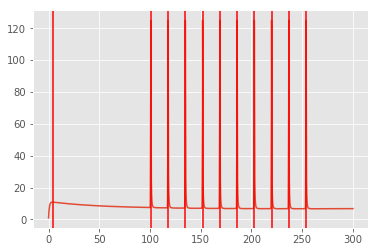

In [92]:
%%time
Collect = dict()
for seclist in [[oc.soma]]:#, oc.dendrites, [oc.soma]]:
    Collect[seclist[0].hname()[:-7]] = dict()
# fig, ax = subplots(1,3,figsize=(10,4))
# suptitle(seclist[0].hname()[:-3], fontsize=18)
    for noi in [0.0]:
#         for interval,col in zip([3,7,10],['om', 'og', 'ok']):
        for interval,col in zip([17],['ro']):
            rec = rec_APsE(oc,seclist, meth=total_seg_e, interval=interval, n=10, noise=noi, tstop=300)
            APE  = individual_AP_E(rec,interval,n=10)
            
            for k in APE.keys():
                APE[k] = array([qe for qe in APE[k] if len(qe)==10])

            APEq = array(APE['interval_'+str(interval)])
            q    = array(APE['int_widths_'+str(interval)])
#             ax[0].plot(mean(q,axis=0),'.',label='int integral')
#             ax[1].plot(mean(APEq,axis=0),'.', label='`Spike` cost')
#             ax[2].plot(mean(q,axis=0)/mean(APEq,axis=0),'.',label='Interval-to-E ratio')
#             ax[0].legend()
#             ax[2].legend()
            Collect[seclist[0].hname()[:-7]]['interval_'+str(interval)] = (q,APEq)

#         vec = sum(APE.values()[0],axis=0)
        #plot(vec/vec.max(),col,label = 'interval='+str(interval))

    #legend()

In [94]:
APE

{'int_widths_17': array([], dtype=float64),
 'interval_17': array([], dtype=float64)}

In [7]:
h.tstop = 400
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [8]:
h.run()

0.0

In [15]:
def setrec(cell):
    t_vec, v_ax, v_sma = h.Vector(),h.Vector(),h.Vector()
    t_vec.record(h._ref_t)
    v_ax.record(cell.ax_init(.5)._ref_v)
    v_sma.record(cell.soma(.5)._ref_v)
    return t_vec,v_ax, v_sma

## Calculate single synEPSP delays while travelling from X position tow. the X=0 (connected to soma)

In [9]:
# #### To calculate single synapse delay time dependance on its distance from the soma 
# #### SAVED to 'delays.txt'
# oc = OctopusCell(Ndendseg=501)
# h.cvode_active(1)
# h.cvode.atol(1e-10)
# %time acc, acc1=oc.find_delays(locs=arange(0,1,0.01),dnm=1,v_init=-59.6)
# acc[1] = acc[1]-acc[1][-1]
# acc[1] = array(acc[1]).max()-acc[1]

# plot(acc[0],acc[1],'.')
# title('EPSPs spread from 1 to 0,\n where connected to soma')
# ylabel('$t_{V_{max}(X=1)}-t_{aud\_start}$', fontsize=15)
# xlabel('$X$', fontsize=15)
# print '***\nTotal travelling wave delay = %.2f ms\n***'%(acc[1].max()-acc[1][0])

In [10]:

# #### Write the delays into a txt file 'delays.txt'
# #### SAVED to 'delays.txt'
# with open('delays.txt','w') as f:
#     for i in [0,1]:
#         f.write("\t".join(map(lambda x: str(x), acc[i])) + "\n")
#     f.close()

### *Fit the delay values with* `lmfit`  *module*

In [11]:
from lmfit import minimize, Parameters

def residual(params, x, data=None, eps_data=1,mode='res'):
    """
    mode = 'res' -> residuals (that to be minimized below) are calculated,
    mode = 'calc'-> `model` values are calculated
    """
    a_hyp =  params['a_hyp']
    a_sin =  params['a_sin']
    sh_hyp = params['shift_hyp']
    sh_sin = params['shift_sin']
    power =  params['power_hyp']
    free =   params['free']

    model =  free + a_hyp/((-x+sh_hyp)**power) + a_sin*sin(-x+sh_sin)
    if mode == 'res':
        return (data-model)/eps_data
    elif mode == 'calc':
        return model
    
params = Parameters()
params.add('a_hyp', value = 1)
params.add('a_sin', value = 1.5)
params.add('shift_hyp', value = 2.3)
params.add('shift_sin', value = 1.3)
params.add('power_hyp', value = 5)
params.add('free', value = -0.7)

In [12]:
x = linspace(0,1,100)
data = []
with open('delays.txt','r') as f:
    data = map(float, f.readlines()[1].split())
# plot(x,data,'.')

In [13]:
eps_data = 1

In [14]:
out = minimize(residual, params, args=(x, data, eps_data))

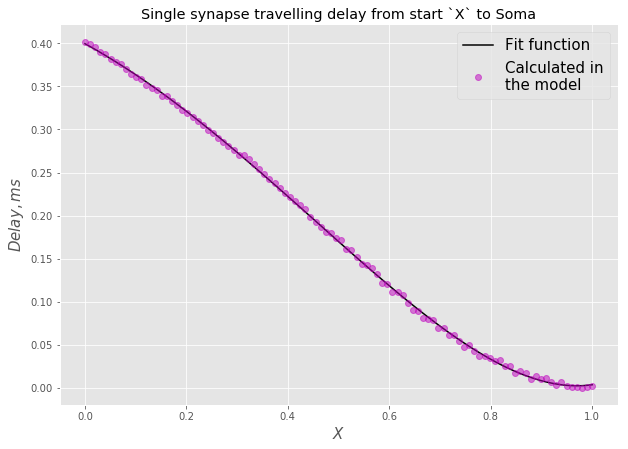

In [16]:
figure(figsize=(10,7))
# errorbar(x,
#          residual(out.params,x,mode='calc'), 
#          yerr=residual(out.params,x,data=data,mode='res'),
#          color='k',label='Fit fuction')
plot(x, residual(out.params, x, mode='calc'), 'k-', label='Fit function')
plot(x,data,'mo', alpha=0.5,label='Calculated in\nthe model')
ylabel('$Delay, ms$', fontsize=15)
xlabel('$X$', fontsize=15)
legend(fontsize=15)
title('Single synapse travelling delay from start `X` to Soma')
# savefig('Delays_fit.pdf')

## So use *`residual(out.params, x, mode='calc')`* to calculate delays; Use synapses locations instead of x

## Setting axon parameters

Lengths of both passive axon "stub" and the inital axon segment with Na conductance are free parameters in Spencer model and can affect its excitability properties. Let's make some not-so-blue-sky guesses on what these values should be based on responses to rectangular current pulses and current ramps. To this end, we must equip our model with the instrumentation to stimulate and detect thresholds.

In [7]:
def setup_pulse_stim(oc, amp=0, delay=10, dur=3):
    oc.stim.delay = delay
    oc.stim.amp= amp
    oc.stim.dur = dur
    
def setup_ramp_stim(oc, dIdt, Imax=6, delay=15, prolong=1.0):
    oc.stim.delay = delay
    oc.stim.dur = Imax/float(dIdt) + prolong
    oc.stim.amp = Imax
    
    tvx = arange(0, oc.stim.dur + delay, h.dt)
#     print tvx
    
    tvh = h.Vector(tvx)     # array(tvh) = array(0, 0+dt, 0+2dt, ..., oc.stim.dur+delay-dt)
    oc.tvramp = tvh
    
    iramp = h.Vector(clip((tvx-oc.stim.delay)*dIdt, 0, Imax))
    
#     plot(tvh, iramp)
    
    iramp.play(oc.stim, oc.stim._ref_amp, h.dt)
    # The following *should* but doesn't work for interpolated vector values
    #iramp.play(oc.stim, oc.stim._ref_amp, tvh, 1)
    
    oc.iramp = iramp
    
def unset_ramp_stim(oc):
    if hasattr(oc, 'iramp'):
        oc.iramp.play_remove()
    
    

------------------------

In [7]:
# ok
def find_threshold(cell, start_range, tol=0.01,
                   vthresh = -25,
                   setter=setup_pulse_stim):
    
    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    
    if not hasattr(cell, 'stim'):
        add_single_pulse_stim(cell)
 
    start_range = np.array(map(float, start_range)) # interval of IClamp amps in which to look for a threash amp
    min_range = tol*np.mean(start_range) # min interval. Sets presision
  
    def spikep(par):  # takes *parameter*, adds synapses to cell with the *parameter* and h.runs recording voltage
                        # Returns max value of voltage of depolarisation over time.
        setter(cell, par)
        h.tstop = cell.stim.delay + cell.stim.dur + 1.0        
        h.run()
        return array(vax).max()
    
    nfix = 10
    ntries = 0
    while not spikep(start_range[1])>vthresh: # "Is it AP?"
        start_range[1] *= 2.0 # if not, widen the min interval
        ntries += 1
        if ntries > nfix:
            print "Can't find threshold: max_amp isn't enough!"
            print "Giving up."
            return False
        
    
    def loop(begin, end):   # Provides boarders of start_range to approach min_range.
                            # Returns min IClamp current amp resulting to AP generation,
                            # and max voltage of the AP.
        if end-begin < min_range:
            return end, spikep(end)
        val = np.mean((begin, end))
        if spikep(val) > vthresh:
            return loop(begin, val)
        else:
            return loop(val, end)

    return loop(start_range[0], start_range[1])

In [8]:
# ok
def plot_around_th(cell, th, setter=setup_pulse_stim, coefs = [0.95, 1, 1.05]):
    f, axs = subplots(2,1,sharex=True, figsize=(9,9))
    
    tv = h.Vector()
    tv.record(h._ref_t)
    
    istim = h.Vector()
    istim.record(cell.stim._ref_i)

    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    #vax.record(cell.soma(0.5)._ref_v) 
    
    for c in coefs:
        setter(cell, c*th)
        h.run()
        axs[0].plot(tv, vax,  label='%0.2f th'%c)
        axs[1].plot(tv, istim,'k-')
        setp(axs[1], ylim=(-0.1, amax(array(cell.istim))*1.2))

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('membrane potential, mV')
    setp(axs[1], xlabel='time, ms', ylabel='Istim')


In [9]:
oc = OctopusCell(Ndendseg=15, ax_init_L=5.0, ax_passive_L=35.0)
print oc.ax_init.L, oc.ax_stub.L

5.0 35.0


In [10]:
unset_ramp_stim(oc)
setup_pulse_stim(oc)

h.tstop = oc.stim.delay + oc.stim.dur + 1.0

%time th = find_threshold(oc, array([1.,6.]))
print th

CPU times: user 451 ms, sys: 2.06 ms, total: 453 ms
Wall time: 457 ms
(3.71484375, -0.45177763011778316)


CPU times: user 302 ms, sys: 12 ms, total: 314 ms
Wall time: 358 ms


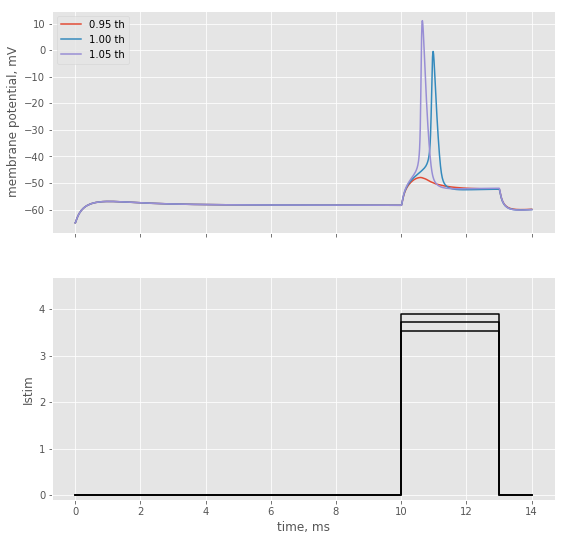

In [11]:
%%time 
plot_around_th(oc, th[0])

In [12]:
from functools import partial

In [13]:
%%time 

fsetter=partial(setup_ramp_stim, Imax=1.5*th[0]) #,prolong=0.1)
th2 = find_threshold(oc, array([0.5,10.]), 
                     vthresh = -25,
                     setter=fsetter)
print th2

(2.94921875, -19.793167457866538)
CPU times: user 1.63 s, sys: 4.9 ms, total: 1.63 s
Wall time: 1.64 s


CPU times: user 671 ms, sys: 6.95 ms, total: 678 ms
Wall time: 675 ms


(15, 20)

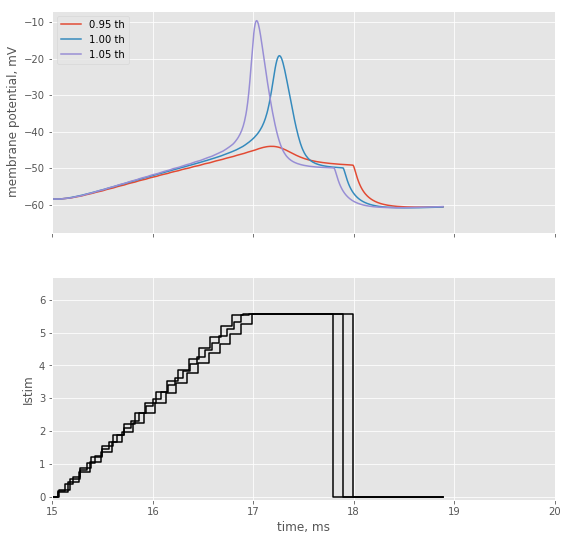

In [14]:
%time plot_around_th(oc, th2[0], setter=fsetter, coefs=[0.95,1.,1.05])    #, coefs=arange(0.9, 1.1, 0.05))
#for line in gcf().axes[0].lines:
#    setp(line, color='k',alpha=0.5)
xlim(15,20)

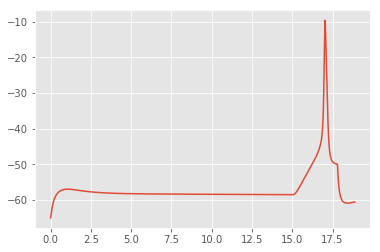

In [15]:
oc.init_records()
h.run()
plot(oc.tv, oc.vax)#; axis((15,16.5,-60,-45))

In [16]:
atv = array(oc.tv)
av = array(oc.vax)

interv = (atv > 15.2)*(atv<16.2)         # Set times where subth voltage is
dvr = diff(av[interv])
mean(dvr)/h.dt                           # Voltage rise velocity before reaching 'AP-threashold'

0.46283772694813408

In [17]:
del oc

## Monte-Carlo look for an admissible range of axonal section lengths

In [30]:
# ok ?
# Generates a list of dicts with ax_act_L an ax_pas_L values taken from uniform an gauss distributions
def generate_psets(Ntrials=10,
                   center_act=15.0,
                   center_pass=15.,
                   nhood=15.,
                   variant = 'uniform',
                   domain=[1.0,50.0]):

    active_w = clip(center_act + nhood*array([-1,1]), *domain) 
    passive_w = clip(center_act + nhood*array([-1,1]), *domain)
    if variant == 'uniform':
        active_Ls = uniform(*active_w, size=Ntrials)
        passive_Ls = uniform(*passive_w, size=Ntrials)
    elif variant == 'gauss':
        active_Ls = clip(randn(Ntrials)*nhood + center_act, *domain)
        passive_Ls = clip(randn(Ntrials)*nhood + center_pass,*domain)
    psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(active_Ls, passive_Ls)]
    return psets

In [31]:
import sys

In [32]:
# Threasholds for a given set of parameters {pulse and ramp stimuli}
def estimate_thresholds(params):
    acc = []
    coef = 1.5
    for k,p in enumerate(params):
        #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
        report =  '\rset #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pth.: {:2.1f} nA, \
rth.: {:2.1f} nA/ms, amp: {:2.1f} mV'
        oc = OctopusCell(Ndendseg=15,**p)
        th1,vsp = find_threshold(oc, array([1, 6]))
        th2 = find_threshold(oc, array([0.5,10.]), setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))[0]

        sys.stderr.write(report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2, vsp))
        acc.append((th1, th2, vsp)) # thresh pulse, ramp, Vmax from pulse
        oc.delete()
        oc = None
        #h('forall delete_section()')
    return array(acc)

In [33]:
def mc_search_parameter_space(Niter=10, Nprime=50,  Next=6, Nbest=3,
                              nhood=2.0, 
                              domain = [(1, 30),(1,50)],
                              max_pulse_th=4.0,
                              min_rate_threshold=4.0,
                              min_peak_vax = -10,
                             ):
    
    
    # Domain corners
    #params = [dict(ax_init_L=l1, ax_passive_L=l2) for l1 in domain[0] for l2 in domain[1]] 
    params = [dict(ax_init_L=l1, ax_passive_L=l2) 
              for l1 in linspace(*domain[0],num=7) 
              for l2 in linspace(*domain[1],num=7)]
    
    # Priming set
    params += generate_psets(Nprime)
    thresholds = estimate_thresholds(params)
    
    def _validate(th):
        return th[0]<=max_pulse_th and th[2]>=min_peak_vax
    
    acc = [(p,t) for p,t in zip(params,thresholds)]
    keep = [(p,t) for p,t in acc if _validate(t)]
    
    
    for i in range(Niter):
        if not len(keep):      # if keep has no len / has len = None:
            break
        best = sorted(keep, key=lambda p: p[1][1], reverse=True)[:min(len(keep),Nbest)]
        print i, len(acc), best[0]
        #best = permutation(keep)[:min(len(keep),Nbest)]
        
        ukeep = []
        
        params = [generate_psets(Next, pset['ax_init_L'], pset['ax_passive_L'],
                                 nhood=nhood, variant='gauss')
                  for pset,t in keep]
        
        params = list(chain(*params))
        thresholds = estimate_thresholds(params)
        update = [(p,t) for p,t in zip(params, thresholds)]
        acc += update
        ukeep = [(p,t) for p,t in update if _validate(t)]
        keep = ukeep
        
        #for pset,th in keep:
        #    params = generate_psets(Next, pset['ax_init_L'], pset['ax_passive_L'],
        #                            nhood=nhood, variant='gauss')
        #    thresholds = estimate_thresholds(params)
        #    update = [(p,t) for p,t in zip(params, thresholds)]
        #    acc += update
        #    ukeep += [(p,t) for p,t in update if _validate(t)]
        #
        #keep = best + ukeep[:]
    return acc    

In [34]:
import pickle

In [35]:
!ls *.pickle

pspace-explored-642.pickle pspace-explored-835.pickle


In [42]:
%%time 

gnabars = linspace(1000,5000,15)

psets = [{'ax_init_L':10, 'ax_passive_L':35, 'ax_gbar_na':g, 'ax_gbar_Ikl':5.0} for g in gnabars]
thresholds = estimate_thresholds(psets)

set #12: ax_init: 10.0, ax_pass: 35.0, pth.: 2.1 nA, rth.: 1.2 nA/ms, amp: 43.1 mV

CPU times: user 34.8 s, sys: 242 ms, total: 35.1 s
Wall time: 36.2 s


set #15: ax_init: 10.0, ax_pass: 35.0, pth.: 2.0 nA, rth.: 1.1 nA/ms, amp: 46.1 mV

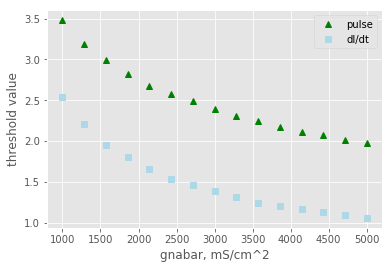

In [44]:
plot(gnabars, [t[0] for t in thresholds], '^',color='green', label='pulse')
plot(gnabars, [t[1] for t in thresholds], 's',color='lightblue',label='dI/dt')
legend()
xlabel('gnabar, mS/cm^2')
ylabel('threshold value') # inserted current amplitude

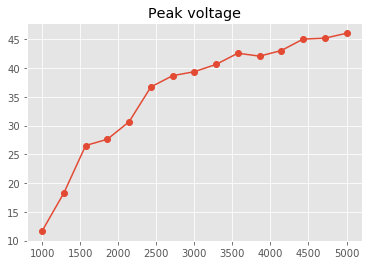

In [45]:
plot(gnabars, [t[2] for t in thresholds], 'o-')
title('Peak voltage')
# xlabel('gnabar, mS/cm^2')

In [46]:
%%time

gklbars = linspace(0,100,25)
psets = [{'ax_init_L':5, 'ax_passive_L':35, 'ax_gbar_na':1600, 'ax_gbar_Ikl':g} for g in gklbars]
thresholds = estimate_thresholds(psets)

set #20: ax_init: 5.0, ax_pass: 35.0, pth.: 4.1 nA, rth.: 3.5 nA/ms, amp: 4.9 mVV

CPU times: user 55 s, sys: 358 ms, total: 55.4 s
Wall time: 56 s


set #25: ax_init: 5.0, ax_pass: 35.0, pth.: 4.2 nA, rth.: 3.7 nA/ms, amp: 4.2 mV

(-60, 50)

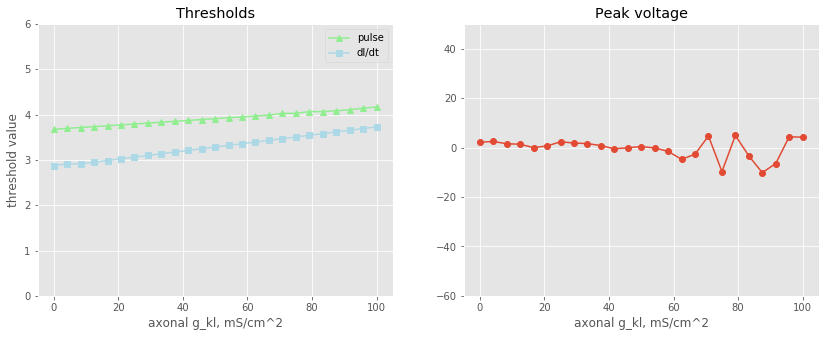

In [47]:
figure(figsize=(14,5))
subplot(121)
title('Thresholds')
plot(gklbars, [t[0] for t in thresholds], '^-',color='lightgreen', label='pulse')
plot(gklbars, [t[1] for t in thresholds], 's-',color='lightblue',label='dI/dt')
legend(loc='best')
xlabel('axonal g_kl, mS/cm^2')
ylabel('threshold value')
ylim(0,6)


subplot(122)
plot(gklbars, [t[2] for t in thresholds], 'o-')
xlabel('axonal g_kl, mS/cm^2')
title('Peak voltage')
ylim(-60,50)

### At some Gkl_bars there are holes in V_maxs
### Search lims in max firing rate with different Gkls

In [48]:
%%time

explored = mc_search_parameter_space(Niter=0, Nprime=50, Nbest=10, Next=1)

set #98: ax_init: 24.3, ax_pass: 29.2, pth.: 2.4 nA, rth.: 1.4 nA/ms, amp: 42.9 mVV

CPU times: user 4min 17s, sys: 3.1 s, total: 4min 20s
Wall time: 4min 28s


set #99: ax_init: 23.6, ax_pass: 2.6, pth.: 2.8 nA, rth.: 1.9 nA/ms, amp: 22.9 mV

In [49]:
%%time 


for d in range(5,50,5):
    for l in range(2, 10,2):
        extended = generate_psets(10, l, d, nhood=2.5, variant='gauss')
        thresholds = estimate_thresholds(extended)

        explored += [(p,t) for p,t in zip(extended, thresholds)]

set #10: ax_init: 6.9, ax_pass: 45.2, pth.: 3.3 nA, rth.: 2.3 nA/ms, amp: 13.6 mVVV

CPU times: user 14min 31s, sys: 4.3 s, total: 14min 35s
Wall time: 14min 43s


In [50]:
%%time
extended = generate_psets(10, 4, 35, nhood=2.5, variant='gauss')
thresholds = estimate_thresholds(extended)
explored += [(p,t) for p,t in zip(extended, thresholds)]

set #7: ax_init: 6.3, ax_pass: 33.2, pth.: 3.5 nA, rth.: 2.6 nA/ms, amp: 11.4 mVV

CPU times: user 23.5 s, sys: 97.9 ms, total: 23.6 s
Wall time: 23.7 s


set #10: ax_init: 1.0, ax_pass: 35.7, pth.: 8.8 nA, rth.: 15.9 nA/ms, amp: -25.0 mV

In [51]:
pickle.dump(explored, open('pspace-explored-%03d.pickle'%randint(1000),'w'))
#explored = pickle.load(open('pspace-explored-181.pickle'))

In [86]:
#Ntrials = 100
#axinit_Ls = uniform(2, 30, size=Ntrials)
#axstub_Ls = uniform(2, 30, size=Ntrials)

#psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(axinit_Ls, axstub_Ls)]

In [87]:
#%%time 
#rate_ths = []
#pulse_ths = []
#coef = 2
#for k,p in enumerate(psets):
#    #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
#    report =  'set #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pulse th.: {:2.1f}, rate th.: {:2.1f}'
#    oc = OctopusCell(Ndendseg=20,**p)
#    th1 = find_threshold(oc, array([1, 6]))
#        
#    th2 = find_threshold(oc, array([0.5,10.]), 
#                         setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))

#    print report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2)
#    pulse_ths.append(th1)
#    rate_ths.append(th2)
#    oc = None

In [18]:
from matplotlib.mlab import griddata

In [ ]:
#explored

In [53]:
xi = np.linspace(1, 30, 200)
yi = np.linspace(1, 50, 200)
# grid the data.

x = [_p['ax_init_L'] for _p,_e in explored]
y = [_p['ax_passive_L'] for _p,_e in explored]

z1,z2,z3 = [[_e[k] for _p,_e  in explored] for k in range(3)] # [th1, th2, Vmaxs]

zi1,zi2,zi3 = [griddata(x, y, z, xi, yi, interp='linear') for z in (z1,z2,z3)]

[None]

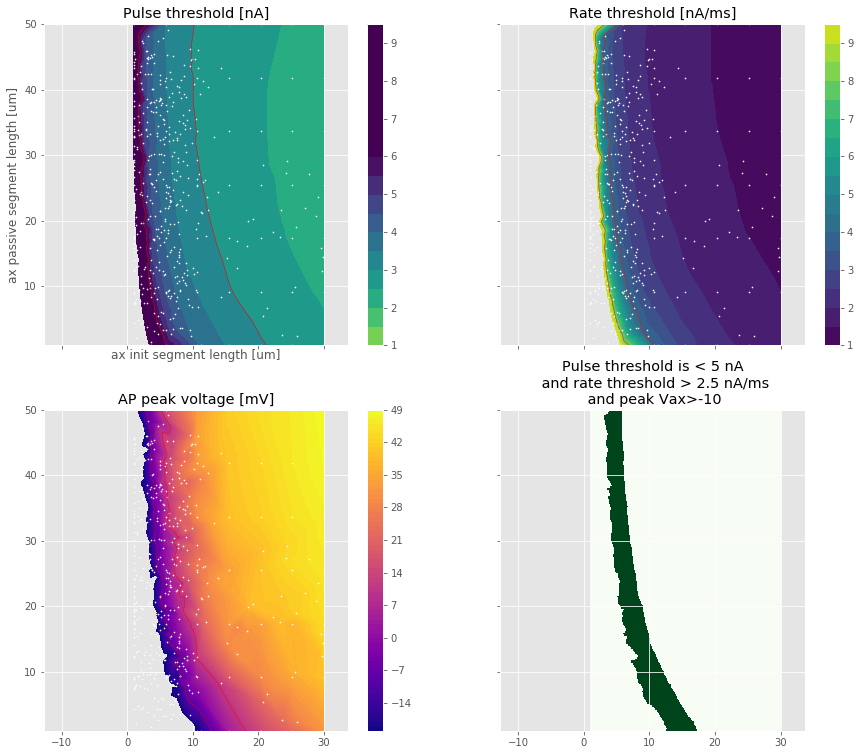

In [54]:
f, axs = subplots(2,2, sharex=True, sharey=True, figsize=(15,13))

axs = ravel(axs)

CS = axs[0].contour(xi, yi, zi1, [3,6], linewidths=0.5, colors='r')
CS = axs[0].contourf(xi, yi, zi1, arange(1,10,0.5), cmap='viridis_r', vmax=6.0, vmin=0)
plt.colorbar(CS,ax=axs[0])  # draw colorbar

axs[0].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[0], title ='Pulse threshold [nA]', xlabel='ax init segment length [um]',
     ylabel='ax passive segment length [um]')



CS = axs[1].contour(xi, yi, zi2, [4,8], linewidths=0.5, colors='r')
CS = axs[1].contourf(xi, yi, zi2, arange(1,10,0.5), vmax=10, cmap='viridis')
plt.colorbar(CS,ax=axs[1])  # draw colorbar

axs[1].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[1], title ='Rate threshold [nA/ms]')


CS = axs[2].contour(xi, yi, zi3, [-10,10], linewidths=0.5, colors='r')
CS = axs[2].contourf(xi, yi, zi3, arange(-20,50), cmap='plasma', vmax=amax(z3), vmin=-20)
plt.colorbar(CS,ax=axs[2])  # draw colorbar

axs[2].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[2], title ='AP peak voltage [mV]')



admiss = (zi2 > 2.5)*(zi1 < 5)*(zi3>-10)
cs = axs[3].imshow(admiss, extent=(1,30,1,50),cmap='Greens', origin='lower')
setp(axs[3], title = "Pulse threshold is < 5 nA\n and rate threshold > 2.5 nA/ms\n and peak Vax>-10")
a = plt.colorbar(cs,ax=axs[3])  # draw colorbar

#xlabel('ax init segment len [um]')
#ylabel('ax passive segment len [um]')

setp(axs[2], xlim=(1,20), ylim=(1,50))
setp(gcf().axes[-1],visible=False)

In [55]:

mx = amax(zi2*admiss)
print mx

row,col = where(mx==zi2*admiss)

print xi[col],yi[row], zi3[row[0],col[0]]

5.87912757799
[ 3.91457286] [ 49.75376884] -1.23979589336


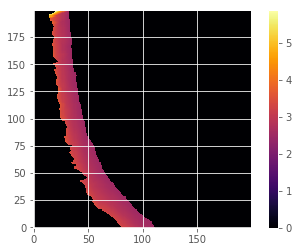

In [56]:
imshow(zi2*admiss,origin='lower',cmap='inferno');colorbar()

## Energy calc

In [7]:
def split_mixed(v, gm, erev,ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh

def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def J2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3


def mouj_Erate2(seg, erev_ih = -38, mode=None):
    """
    mode==None => all currents are calculated;
    mode=='noIh' => all currents without Ih are calculated
    """
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.gh_ihsab, 
                            erev_ih, seg.ek, seg.ena) # раскладываем Ih на компоненты

    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K

    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    acc = acc*seg.area()*factor
    if mode == None:
        return [acc]
    elif mode == 'hkl':
        acch = abs(inah*(v-seg.ena)) + abs(ikh*(v-seg.ek))
        acckl = abs(seg.kltab.ik*(v - seg.ek))
        acch = acch*seg.area()*factor
        acckl = acckl*seg.area()*factor
        acclk = seg.i_leak*(v-seg.erev_leak)*seg.area()*factor
        return [acc, acch, acckl, acclk]
        

def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

## Adding synapses

In [58]:
oc1.delete()
oc2.delete()
oc.delete()
del oc1, oc2, oc

NameError: name 'oc1' is not defined

In [283]:
h.topology()

1.0

In [60]:
oc1 = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
oc2 = OctopusCell(ax_init_L = 6., ax_passive_L = 35)

Nsyn = 252
gsyn = 1.1
rate = 256.


# oc2.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy='random')
[oc.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy=ton) 
 for oc,ton in ((oc1, 'ordered'), (oc2,'random'))]


print 'done'

done


In [61]:
h.cvode_active(0)
h.dt = 0.005
#h.cvode_active(1)
#print h.cvode.atol()
#h.cvode.atol(5e-4)

In [53]:
#

In [62]:
#oc1.init_records()
def trial_run():
    oc2.init_records()
    h.tstop = 500
    h.v_init = -60.0
    %time h.run()
    return map(array, (oc2.tv, oc2.vax))



Сравним разные методы интегрирования: с фиксированным шагом при разном $dt$ и с адаптивным шагом при разном $atol$. При этом клетка со случайно разбросанными синапсами одна и та же.

In [63]:
h.cvode_active(0)
dtfix = (0.02, 0.01, 0.005)

fixed = []
for dt in dtfix:
    h.dt = dt
    fixed.append(trial_run())

CPU times: user 32.8 s, sys: 155 ms, total: 33 s
Wall time: 33.2 s
CPU times: user 1min 9s, sys: 625 ms, total: 1min 10s
Wall time: 1min 13s
CPU times: user 2min 42s, sys: 1.45 s, total: 2min 43s
Wall time: 2min 45s


In [64]:
h.cvode_active(1)

atols = (1e-2, 1e-3, 5e-4, 1e-4)

adaptive = []
for atol in atols:
    h.cvode.atol(atol)
    adaptive.append(trial_run())

CPU times: user 1min 16s, sys: 707 ms, total: 1min 17s
Wall time: 1min 17s
CPU times: user 1min 40s, sys: 887 ms, total: 1min 41s
Wall time: 1min 42s
CPU times: user 1min 52s, sys: 1.04 s, total: 1min 53s
Wall time: 1min 54s
CPU times: user 2min 48s, sys: 1.66 s, total: 2min 50s
Wall time: 2min 52s


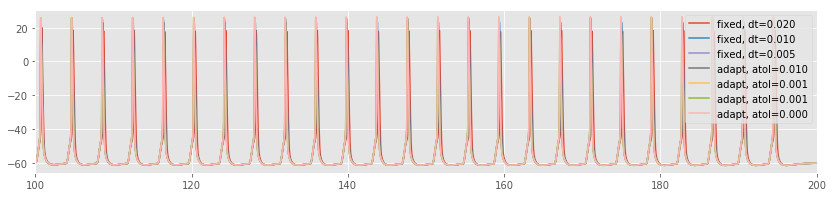

In [65]:
figure(figsize=(14,3))

for (tv,av),dt in zip(fixed, dtfix):
    plot(tv, av, label='fixed, dt=%0.3f'%dt)
    
for (tv,av),at in zip(adaptive, atols):
    plot(tv, av, label='adapt, atol=%0.3f'%at)


xlim(100,200)    
legend()


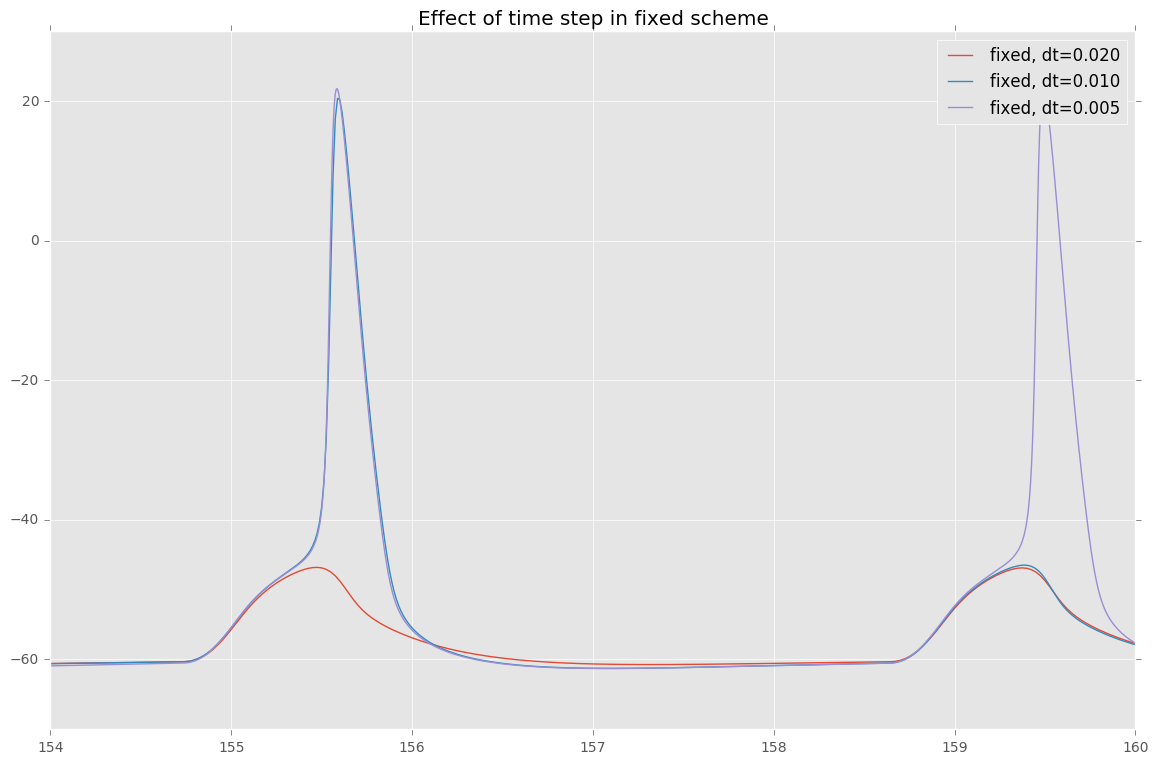

In [291]:
figure(figsize=(14,9))

for (tv,av),dt in zip(fixed, dtfix):
    plot(tv, av, label='fixed, dt=%0.3f'%dt)
    
title('Effect of time step in fixed scheme')
    
xlim(154,160)    
legend()


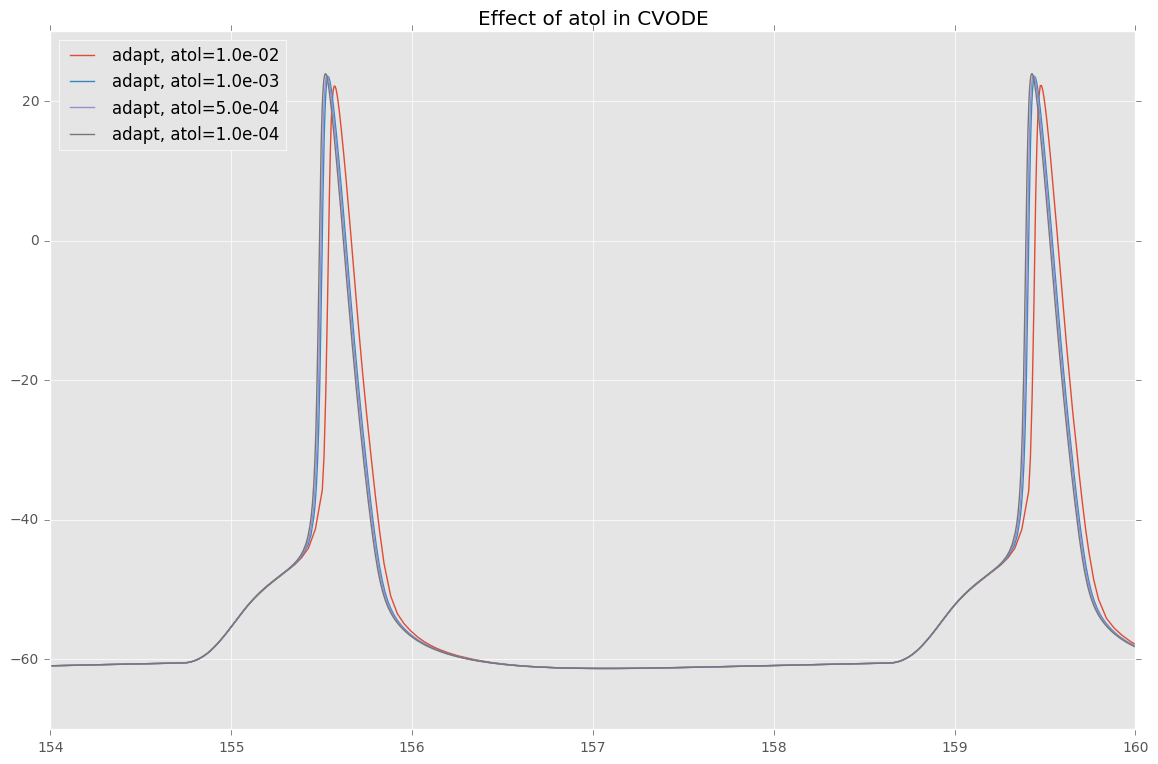

In [292]:
figure(figsize=(14,9))

for (tv,av),at in zip(adaptive, atols):
    plot(tv, av, label='adapt, atol=%0.1e'%at)

title('Effect of atol in CVODE')
xlim(154,160)    
legend(loc='best')


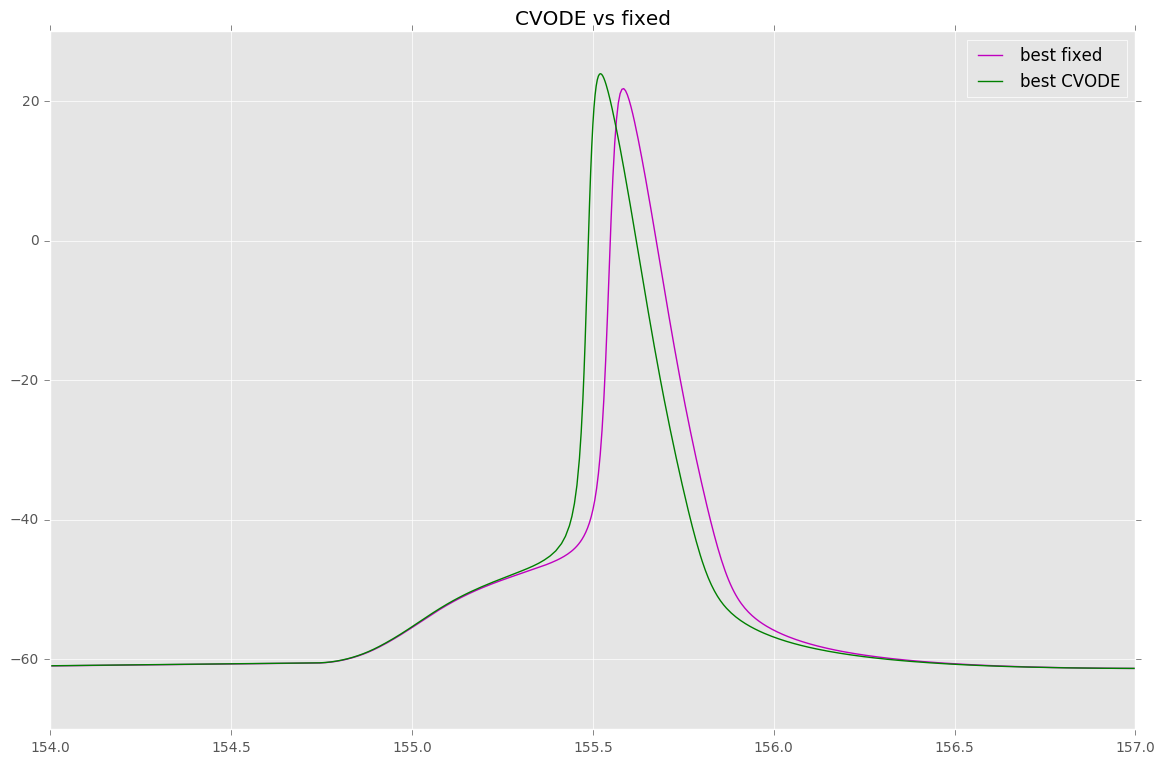

In [293]:
figure(figsize=(14,9))

title('CVODE vs fixed')
plot(*fixed[-1],color='m',label='best fixed')
plot(*adaptive[-1],color='g',label='best CVODE')
legend(loc='best')
xlim(154,157)    
legend(loc='best')

**Вывод:** *При исследовании синаптических входов будем использовать **CVODE с atol=1e-3***

In [39]:
oc2.delete()
oc.delete()
oc1.delete()
oc3.delete()
del oc,oc1,oc2,oc3

NameError: name 'oc2' is not defined

In [69]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [297]:
h.topology()

1.0

In [8]:
# Calc AP_number/npulses under different Nsyns

##### ***To be put into OC Class***

def count_synapses(Nsynv, gsyn=1.0, rate=256., npulses=25.,tonotopy='ordered',
                   meth=0, delay_func=None,
                   dnm=[0,1,2,3], full_delay = 0.3):
    """
    Setting ``meth``=0 make synapses with ``add_synapses`` function.
    Set ``meth=1`` -- with ``add_several_syn`` (see OctopusCell class).
    """
    acc = []
    oca = OctopusCell(ax_init_L = 5., ax_passive_L = 35) # Create a single cell. Then rewrite oc.synapses
    for Nsyn in Nsynv:
        if meth == 0:
            oca.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate,
                            tonotopy=tonotopy, full_delay = full_delay)
        elif meth == 1:
            if delay_func == None:
                print "Ooops... You should specify the ``delay_func`` while using meth = 1"
#                 break
            oca.add_several_syn(locs=linspace(0,1,Nsyn), gsyn=gsyn,
                               afibp=dict(aud_rate=rate,
                                          aud_start=100,
                                          aud_npulses=npulses,
                                          aud_jitter=0.0),
                               dnm=dnm, delay_func=delay_func)
        apc = h.APCount(oca.ax_init(0.5))
        apc.thresh=-20
        h.tstop = 500
        h.v_init = -60.0
        h.run()
        sys.stderr.write('\r%d synapses, spike ratio: %0.2f'%(Nsyn, apc.n/npulses))
        acc.append([Nsyn, apc.n/npulses])  
        del apc
    oca.delete()
    del oca
    return acc  

# # vary pulse_rate and 
# def count_synapses_hz(Nsyn, gsyn=1.0, Ratev, npulses=25., tonotopy='ordered'):###
#     acc = []
#     for rate in Ratev:
#         oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
#         oc.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy=tonotopy)
#         apc = h.APCount(oc.ax_init(0.5), )
#         apc.thresh=-20
#         h.tstop = 500
#         h.v_init = -60.0
#         h.run()
#         sys.stderr.write('\r%d Hz pulse_rate, spike ratio: %0.2f'%(rate, apc.n/npulses))
#         acc.append([Nsyn, rate, apc.n/npulses]) 
#         oc.delete()
#         del oc, apc    
#     return acc

def syn_rate_spase(Nsynv, Ratev):
    acc = []
    for rate in Ratev:
        acc.append([rate]+[i for i in count_synapses(Nsynv, rate=rate)])
    return acc # returns [None, None]...

In [68]:
# %time acc = syn_rate_spase(range(225,301,5), range(256,507,50))

250 synapses, spike ratio: 0.52

KeyboardInterrupt: 

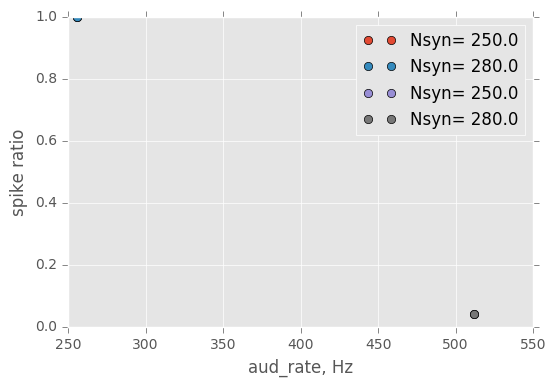

In [100]:
# for i in acc:
#     ar = transpose([i[1]]+[i[2]])
# #     print ar
#     for j in [0,1]:
#         plot(i[0],ar[1][j],'o',label='Nsyn= '+str(ar[0][j]))
#     legend()
# ylabel('spike ratio')
# xlabel('aud_rate, Hz')

### Still calc APratio of Nsyn dependense 

In [17]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [333]:
%time acc_l3 = [count_synapses(range(220,261,5),full_delay=0.3) for i in range(5)]
# nsynsl3,countsl3 = array(acc_l3).T

245 synapses, spike ratio: 0.52

CPU times: user 1h 51min 51s, sys: 9.18 s, total: 1h 52min
Wall time: 1h 52min 17s


260 synapses, spike ratio: 1.00

In [32]:
# with open('Count_synapses_linear_delays_fulldelay03.txt','w') as f:
#     for i in [0,1]:
#         f.write("\t".join(map(lambda x: str(x), array(acc_l3).T[i])) + "\n")
#     f.close()

In [38]:
# %time acc_l = count_synapses(range(230,256),full_delay=0.4)
# nsynsl,countsl = array(sorted(acc_l, key=lambda _e: _e[0])).T

252 synapses, spike ratio: 1.00

CPU times: user 19min 8s, sys: 4.03 s, total: 19min 12s
Wall time: 19min 22s


255 synapses, spike ratio: 1.00

In [40]:
# with open('Count_synapses_linear_delays_fulldelay04.txt','w') as f:
#     for i in [0,1]:
#         f.write("\t".join(map(lambda x: str(x), array(acc_l).T[i])) + "\n")
#     f.close()

In [41]:
### meth=1 mode sets Nsyn synapses in each separate dendrite. Use Nsyn number Ndend times 
%time acc_df = count_synapses(range(230,256),meth=1,delay_func=lambda x: residual(out.params, x, mode='calc'))
nsynsdf,countsdf = array(sorted(acc_df, key=lambda _e: _e[0])).T  

253 synapses, spike ratio: 1.00

CPU times: user 20min 28s, sys: 912 ms, total: 20min 28s
Wall time: 20min 29s


255 synapses, spike ratio: 1.00

In [42]:
# with open('Count_synapses_delay_func_fulldelay04.txt','w') as f:
#     for i in [0,1]:
#         f.write("\t".join(map(lambda x: str(x), array(acc_df).T[i])) + "\n")
#     f.close()

In [147]:
%time acc_r1 = [count_synapses(range(240,321,10),tonotopy='random') for i in range(32)]
nsynsr,countsr = mean(acc_r1,axis=0).T

310 synapses, spike ratio: 1.00

CPU times: user 4h 5min 22s, sys: 13.8 s, total: 4h 5min 36s
Wall time: 4h 5min 59s


320 synapses, spike ratio: 1.00

In [148]:
acc_r1 = [array(acc_r1[i]).T for i in range(31)]

In [343]:
acc_l33 = [array(acc_l3[i]).T for i in range(len(acc_l3))]

In [78]:
# with open('Count_synapses_random_fulldelay04_mean5.txt','w') as f:
#     for i in [0,1]:
#         f.write("\t".join(map(lambda x: str(x), mean(acc_r1,axis=0).T[i])) + "\n")
#     f.close()

In [153]:
nsynsr=acc_r1[0][0]

In [162]:
nsynsr=acc_r1[0][0]
countsr_std=std(acc_r1,axis=0)[1]

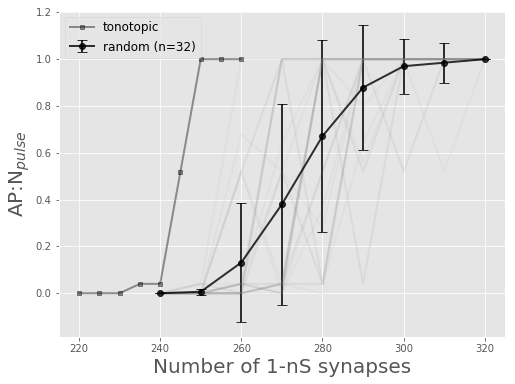

In [349]:
figure(figsize=(8,6))
plot(nsynsl3,countsl3, 'ks-',markersize=4, linewidth=2, label='tonotopic',alpha=0.4)
for i in range(31):
    plot(acc_r1[i][0], acc_r1[i][1], 'k-',markersize=4,linewidth=2, color='gray', alpha=0.05)
errorbar(nsynsr,countsr,yerr=countsr_std,fmt='ok-', alpha=0.8,lw=2, capsize=5, label='random (n=32)')
legend(loc='best', fontsize=12)
xlabel('Number of 1-nS synapses', fontsize=20)
# ylim(-0.1,1.1)
# xlim(225,325)
ylabel('AP:N$_{pulse}$',fontsize=20)
# savefig('Random-Ordered.pdf') (15.08.17 for article)

In [151]:
a,b= dict(),dict()

In [4]:
with open('Count_synapses_random_fulldelay04_mean5.txt','r') as f:
    a = {k:v for k,v in zip(['Nsyn','APratio'],[map(float, l.split()) for l in f.readlines()])}
with open('Count_synapses_linear_delays_fulldelay04.txt','r') as f:
    b = {k:v for k,v in zip(['Nsyn','APratio'],[map(float, l.split()) for l in f.readlines()])}
        

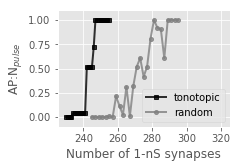

In [9]:
figure(figsize=(3.5,2.5))
# plot(nsynsl3,countsl3, 'bo-', label='ordered, tot_delay=0.3 ms')
plot(b['Nsyn'],b['APratio'], 'ks-',markersize=4,linewidth=2, label='tonotopic',alpha=0.8)
plot(a['Nsyn'],a['APratio'], 'o-',markersize=4,linewidth=2, color='gray', label='random',alpha=0.8)
# plot(nsynsdf,countsdf, '^-',color='m', label='delay function\ntot_delay=0.4 ms')
# title('Spike:pulse ratio at 256 Hz stimulation')
legend(loc='best')
xlabel('Number of 1-nS synapses')
ylim(-0.1,1.1)
xlim(225,325)
ylabel('AP:N$_{pulse}$')
tight_layout(pad=1.3)
# savefig('Spike_ratio256Hz_lin_random2.pdf') # ~ 15.03.17 for poster in Berlin Brain and SymBioSE

In [ ]:
# Reproduce this image using:

# def open_fle(flename):
#     data = []
#     with open(flename) as f:
#         for i in f.readlines():
#             data.append(map(float, i.split()))
#     return data

# names = ['Count_synapses_delay_func_fulldelay04.txt',
#          'Count_synapses_linear_delays_fulldelay04.txt',
#          'Count_synapses_random_fulldelay04_mean5.txt']
# for name in names:
#     data = open_fle(name)
#     plot(data[0],data[1], label=name[15:21])
# legend()

## Run control from Python and energy accounting

In [308]:
#axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33

In [24]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [407]:
chain(oc1.soma,*oc1.dendrites)

In [9]:
h.dt = 0.01
tstop = 400

h.v_init = -60.6

def initialize():
    h.finitialize(h.v_init) # makes v = h.v_init and computes and fix corresponding state variables 
    h.fcurrent() # make all assigned variables consistent with the values of states

    
def instant_erates(cell,mode=None):
    """
    mode = None -> only total compartments energy count
    mode = 'hkl' -> plus energy for Ih and Ikl 
    """
    syn_erate = np.sum([synaptic_curr2pJ(s,dseg) for s,c,dseg,d in cell.synapses])
    soma_erate = mouj_Erate2(cell.soma(0.5),mode=mode)[0] # mouj_Erate2 generates a list [acc] (mode=None) or [acc, acch, acckl] (mode='hkl')
    dend_erate = np.sum([mouj_Erate2(seg,mode=mode)[0] for seg in chain(*cell.dendrites)])
    axon_erate = np.sum([mouj_Erate2(seg,mode=mode)[0] for seg in chain(cell.ax_init,cell.ax_stub)])
    if mode == None:
        return axon_erate, soma_erate, dend_erate, syn_erate
    elif mode == 'hkl':
        h_erate = np.sum([mouj_Erate2(seg,mode=mode)[1] 
                          for seg in chain(cell.dendrites[0],cell.dendrites[1],cell.dendrites[2],cell.dendrites[3],
                                           cell.soma, cell.ax_init, cell.ax_stub)])
        kl_erate = np.sum([mouj_Erate2(seg,mode=mode)[2] 
                          for seg in chain(cell.dendrites[0],cell.dendrites[1],cell.dendrites[2],cell.dendrites[3],
                                           cell.soma, cell.ax_init, cell.ax_stub)])
        return axon_erate, soma_erate, dend_erate, syn_erate, h_erate, kl_erate
    
def integrate_collecting_energy(cells,mode=None):

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate']
    if mode == 'hkl':
        keepvar += ['ih.erate','ikl.erate'] # total ih and ikl erates

    outs = [{key:[] for key in keepvar} for i in range(len(cells))]

    while h.t < tstop:
        h.fadvance() # 
        #isyn = np.sum([syn.i for syn in synapses])
        
        erates = map((lambda x: instant_erates(x, mode=mode)),cells)
        
        for cell, o, erate in zip(cells, outs, erates):
            o['t'].append(h.t)
            o['axon.v'].append(cell.ax_init.v)
            o['soma.v'].append(cell.soma.v)
            o['axon.erate'].append(erate[0]) # mouj_Erate2 generates a list [acc] (mode=None) or [acc, acch, acckl] (mode='hkl')
            o['soma.erate'].append(erate[1])
            o['dend.erate'].append(erate[2])
            o['syn.erate'].append(erate[3])
            if mode == 'hkl':
                o['ih.erate'].append(erate[4])
                o['ikl.erate'].append(erate[5])
        sys.stderr.write('\r model time: %0.5f ms '%h.t)
    sys.stderr.write('\r                                         \r\n')

    return [{key:np.array(vec) for key,vec in out.items()} for out in outs]

def go(cells,mode=None):
    initialize()
    return integrate_collecting_energy(cells, mode=mode)
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].legend()

In [110]:
oc1.delete()
oc2.delete()
del oc1, oc2
h.topology()

NameError: name 'oc1' is not defined

In [10]:
oc1,oc2 = OctopusCell(),OctopusCell()
rate = 256.
oc1.add_synapses(tonotopy='ordered',gsyn=1.0, Nsyn=250, aud_rate=rate)
oc2.add_synapses(tonotopy='random',gsyn=1.0, Nsyn=290, aud_rate=rate)
# oc3.add_several_syn(locs=linspace(0,1,250),
#                     gsyn=1.0,
#                     afibp={'aud_npulses': 25,
#                            'aud_jitter': 0.0,
#                            'aud_start': 100,
#                            'aud_rate': 256}, dnm=[0,1,2,3],
#                     delay_func=lambda x: residual(out.params, x, mode='calc'))

In [11]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [41]:
h.cvode_active(0)

0.0

In [43]:

%time data = go([oc1])
# %time data_noIh = go([oc1,oc2,oc3], mode='noIh')

 model time: 399.93000 ms 

CPU times: user 5min 18s, sys: 1min 2s, total: 6min 21s
Wall time: 5min 31s


In [44]:
data_o = data[0]

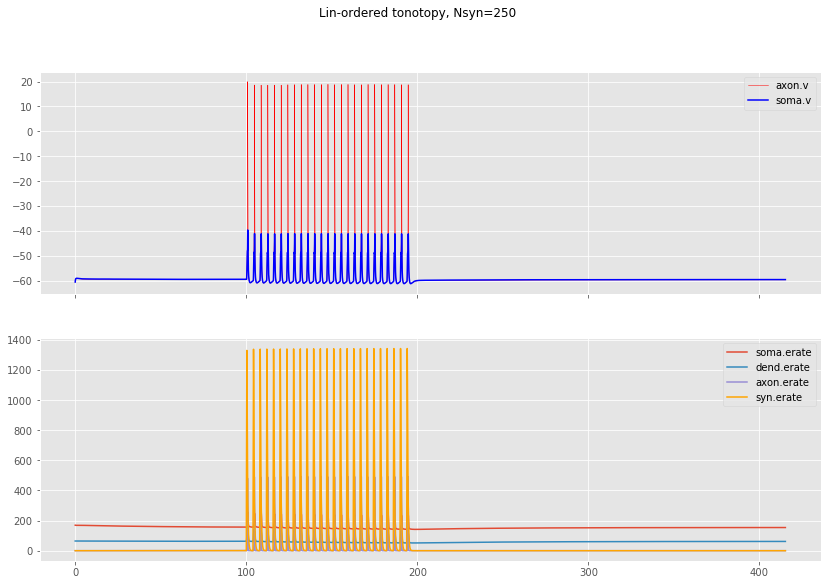

In [25]:
plot_traj(data[0])
suptitle('Lin-ordered tonotopy, Nsyn=250')

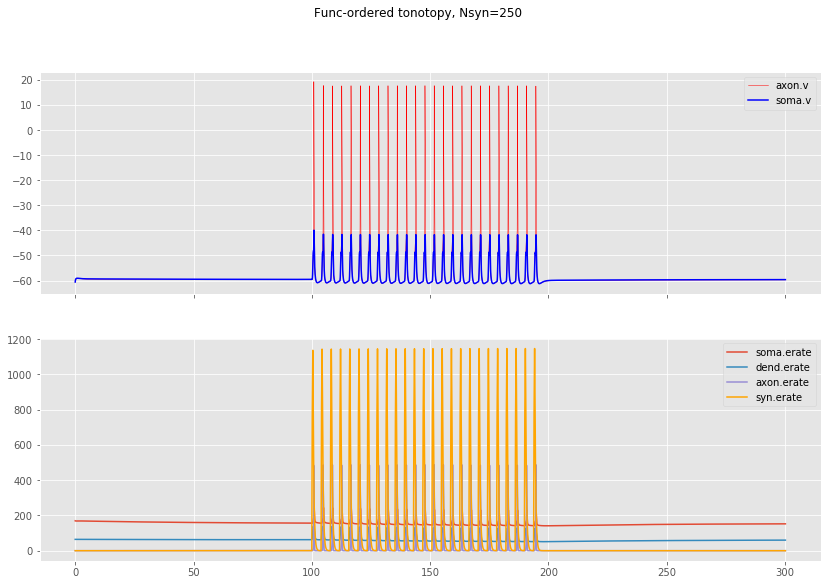

In [24]:
plot_traj(data[2])
suptitle('Func-ordered tonotopy, Nsyn=250')

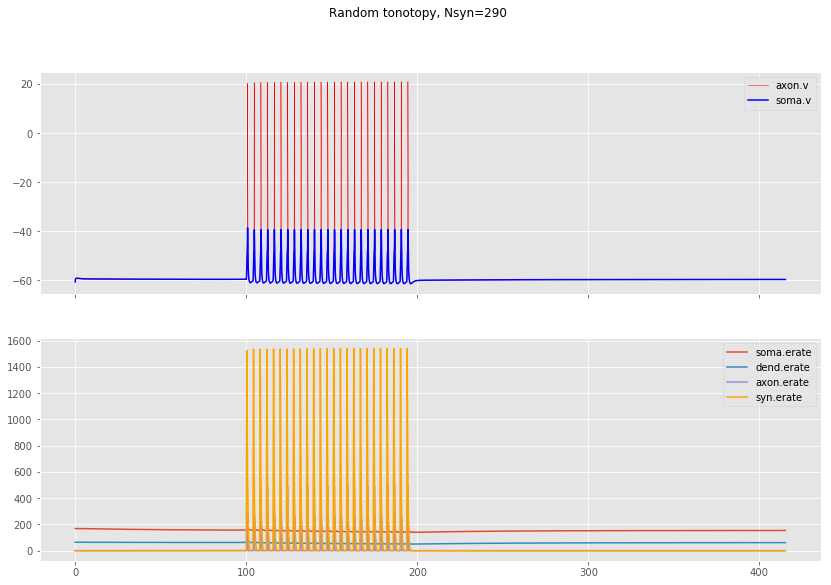

In [26]:
plot_traj(data[1])
suptitle('Random tonotopy, Nsyn=290')

In [332]:
plot_traj(data[0])
xlim(170,173)
suptitle('Lin-ordered tonotopy, Nsyn=250')

NameError: name 'plot_traj' is not defined

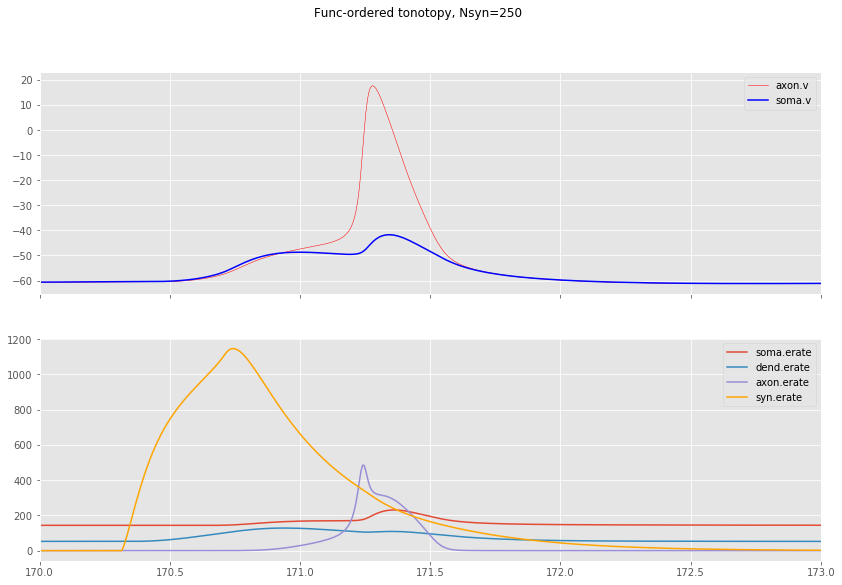

In [37]:
plot_traj(data[2])
xlim(170,173)
suptitle('Func-ordered tonotopy, Nsyn=250')

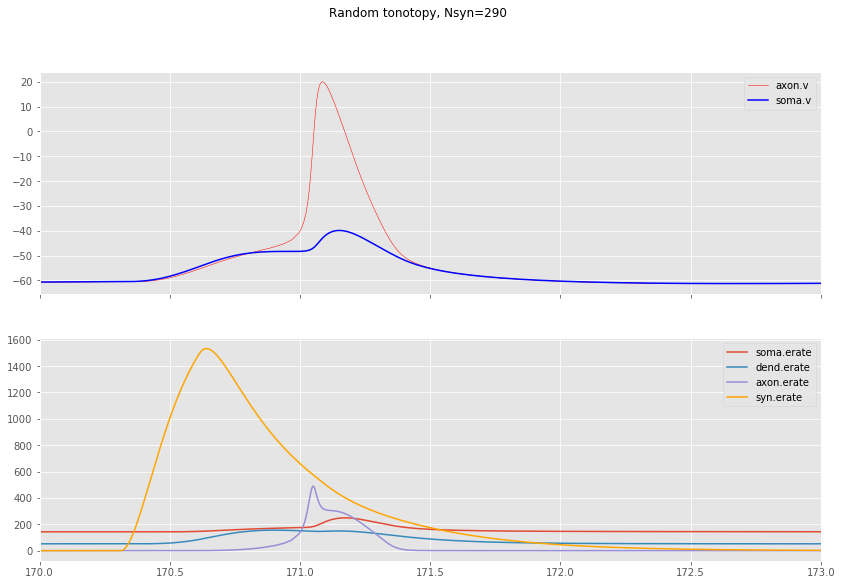

In [38]:
plot_traj(data[1])
xlim(170,173)
suptitle('Random tonotopy, Nsyn=290')

Random -- меньше всех отстает на последующих ПД

In [45]:
%%time

Ntrials = 2#10
data_r = []
rate = 256.
for i in range(Ntrials):
    oc = OctopusCell()
    oc.add_synapses(tonotopy='random',gsyn=1.0, Nsyn=300, aud_rate=rate)
    data_r.append(go([oc]))
    oc.delete()
    del oc

                                         
 model time: 399.99000 ms 

CPU times: user 12min 25s, sys: 2min 26s, total: 14min 52s
Wall time: 12min 43s


In [38]:
oc1 = OctopusCell()
oc1.add_synapses(tonotopy='ordered',gsyn=1.0, Nsyn=250, aud_rate=rate)
data_o = go([oc1])[0]

(150, 153)

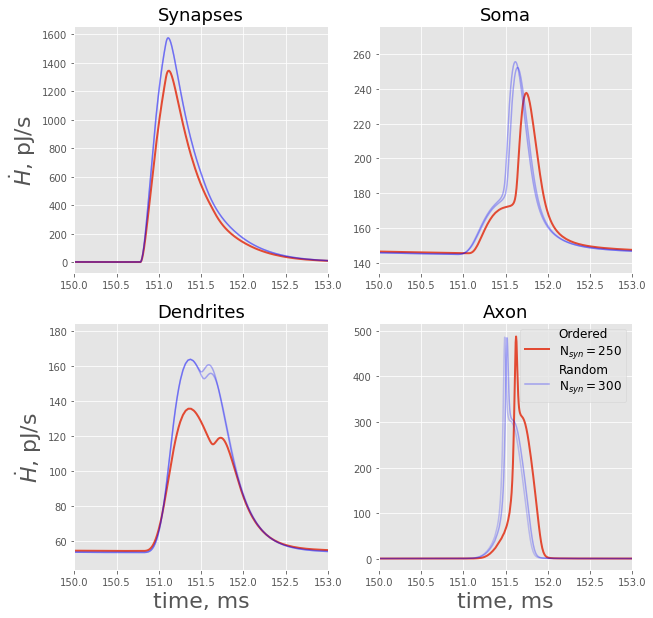

In [40]:
x_0,x_1 = 150,153
N_rand = 2

figure(figsize=(10,10))
subplot(2,2,3)
plot(data_o['t'], data_o['dend.erate'], label='ordered',lw=2)
for i in range(N_rand):
    plot(data_r[i][0]['t'], data_r[i][0]['dend.erate'], label='random', color='b', alpha=0.3)
# plot(oc3_traj['t'], oc3_traj['dend.erate'], label='func-ordered')
title('Dendrites',fontsize=18)
xlabel('time, ms', fontsize=22)
ylabel('$\dot{H}$, pJ/s', fontsize=22)

xlim(x_0, x_1)

subplot(2,2,2)
plot(data_o['t'], data_o['soma.erate'], label='ordered',lw=2)
for i in range(N_rand):
    plot(data_r[i][0]['t'], data_r[i][0]['soma.erate'], label='random', color='b', alpha=0.3)
# plot(oc3_traj['t'], oc3_traj['soma.erate'], label='func-ordered')
title('Soma',fontsize=18)
# xlabel('time, ms')
#ylabel('E rate, pJ/s')
#legend()
xlim(x_0, x_1)


subplot(2,2,1)
plot(data_o['t'], data_o['syn.erate'], label='ordered',lw=2)
for i in range(N_rand):
    plot(data_r[i][0]['t'], data_r[i][0]['syn.erate'], label='random', color='b', alpha=0.3)
# plot(oc3_traj['t'], oc3_traj['syn.erate'], label='func-ordered')
title('Synapses',fontsize=18)
# xlabel('time, ms')
ylabel('$\dot{H}$, pJ/s', fontsize=22)
#legend()
xlim(x_0, x_1)


subplot(2,2,4)
plot(data_o['t'], data_o['axon.erate'], label='Ordered\nN$_{syn}=250$',lw=2)
for i in range(N_rand):
    if i == 0:
        plot(data_r[i][0]['t'], data_r[i][0]['axon.erate'], label='Random\nN$_{syn}=300$', color='b', alpha=0.3)
    else:
        plot(data_r[i][0]['t'], data_r[i][0]['axon.erate'], color='b', alpha=0.2)
# plot(oc3_traj['t'], oc3_traj['axon.erate'], label='func-ordered')
title('Axon',fontsize=18)
xlabel('time, ms', fontsize=22)
# ylabel('E rate, pJ/s', fontsize=22)
legend(loc='best',fontsize=12)
xlim(x_0, x_1)

# savefig('Ordered-random-Erate-curves.pdf') # (15.08.17 for article)


1) В любом случае (распределять синапсы lin-ordered или func-ordered), беспорядочнее --> больше синапсов надо для ПД -->  больше энергозатрат. На сколько ?
2) В случае func-ordered, синаптические энергозатраты пониже. На сколько? 

#### Проинтегрировать

(100, 102)

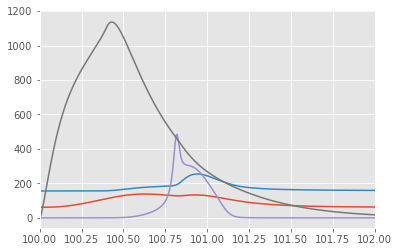

In [956]:
plot(oc1_traj['t'],oc3_traj['dend.erate'])
plot(oc1_traj['t'],oc3_traj['soma.erate'])
plot(oc1_traj['t'],oc3_traj['axon.erate'])
plot(oc1_traj['t'],oc3_traj['syn.erate'])
xlim(100,102)

In [130]:
def Etotal(data,timeival):
    indxival = map(lambda x: find_nearest(data['t'],x), timeival)
#     print indxival

    Esyn = trapz(y=data['syn.erate'][indxival[0]:indxival[1]], x=data['t'][indxival[0]:indxival[1]])*1e-3 # ms -> s => pJ
    Ednd = trapz(y=data['dend.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    Eaxn = trapz(y=data['axon.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    Esma = trapz(y=data['soma.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 

    Etot = Esyn+Ednd+Esma+Eaxn
#     print 'Note, you calculate energy during %.2f ms'%(timeival[1]-timeival[0])
    acc = {'tot.erate':Etot,'soma.erate':Esma,'axon.erate':Eaxn,'dend.erate':Ednd,'syn.erate':Esyn}
    for key,val in acc.items():
        acc[key] = J2atp(val)*6.022*(10**11) 
    return acc

In [135]:
Etotal(data_r[0][0], [100,102])

{'axon.erate': 1109664.2214517996,
 'dend.erate': 2438487.9930794449,
 'soma.erate': 4110590.2748647905,
 'syn.erate': 10959429.796789266,
 'tot.erate': 18618172.286185302}

In [13]:
Eactivefun = Etotal(oc3_traj,[100, 102])
Erestfun =   Etotal(oc3_traj,[90, 92])

NameError: name 'oc3_traj' is not defined

In [ ]:
Eactivelin = Etotal(oc1_traj,[100, 102])
Erestlin =   Etotal(oc1_traj,[90, 92])

In [ ]:
Eactiver = Etotal(oc2_traj,[100, 102])
Erestr =   Etotal(oc2_traj,[90, 92])

In [1048]:
print 'TOTAL Erate\n------------'
print 'Linear synapses.\nREST: %.3e ATPs/2ms \nAP (2 ms): %.3e ATPs/Excitation'%(Erestlin['Etot'],Eactivelin['Etot'])
print'----'
print 'Delay_func synapses.\nREST: %.3e ATPs/2ms \nAP (2 ms): %.3e ATPs/Excitation'%(Erestfun['Etot'],Eactivefun['Etot'])
print'----'
print 'Random synapses.\nREST: %.3e ATPs/2ms \nAP: %.3e ATPs/Excitation'%(Erestr['Etot'],Eactiver['Etot'])

TOTAL Erate
------------
Linear synapses.
REST: 4.151e+06 ATPs/2ms 
AP (2 ms): 1.686e+07 ATPs/Excitation
----
Delay_func synapses.
REST: 4.151e+06 ATPs/2ms 
AP (2 ms): 1.681e+07 ATPs/Excitation
----
Random synapses.
REST: 4.151e+06 ATPs/2ms 
AP: 1.843e+07 ATPs/Excitation


In [352]:
1.843-0.415

1.428

# -------------(15.08.17 for article)
$H_{AP} = H_{Excitation} - H_{rest} = 1.271\cdot 10^7$ ATPs/AP [linear synapses]
$1.428\cdot 10^7$ ATPs/AP [random synapses]
------------------------

In [354]:
# energy efficiency gain from ordered synapses (15.08.17 for article)
(1.428-1.271)/1.428 * 100

10.994397759103643

In [1049]:
import pandas

# integrate between boarders set, eg 100:102:
# FOR ARTICLE

In [1050]:
l = [Erestr,Eactiver,Eactivelin,Eactivefun]
pandas.DataFrame(data=l,index=['Rest','Random','Linear','Delay_func'])

,Eaxon,Edend,Esoma,Esyn,Etot
Rest,1.965824e+03,1.178402e+06,2.970626e+06,0.000000e+00,4.150993e+06
Random,1.127935e+06,2.437920e+06,4.166951e+06,1.069245e+07,1.842525e+07
Linear,1.142117e+06,2.258084e+06,4.110669e+06,9.350558e+06,1.686143e+07
Delay_func,1.145304e+06,2.235925e+06,4.098350e+06,9.334841e+06,1.681442e+07


In [367]:
# 15.08.17 for article
for i,j in zip([1.142e6,2.258e6,4.111e6,9.351e6,1.686e7],['ax   ','dnd  ','sma  ','syn  ','total']):
    print j+' -- %.3e'%(i*500)

ax    -- 5.710e+08
dnd   -- 1.219e+09
sma   -- 2.084e+09
syn   -- 5.345e+09
total -- 9.215e+09


### Dля выделения нужных границ интегрирования

In [11]:
import math

def deriv(y,x):
    count=[0,0]
    if len(y) != len(x):
        return 'Y and X length are different!'
    deriv = []
    for i in range(len(y)-1):
#         if i == 0:
#             der = (y[i+2]-y[i])/(x[i+2]-x[i])
#         else:
        der = (y[i+1]-y[i])/(x[i+1]-x[i])
        if math.isnan(der) == True:
            count[0] += 1
            der = deriv[i-1] # change every NaN to the previous value. Max() cannot be found if there are NaNs
                                # The previous vlue is chosen as on a certain interval NaNs interchange with non-Nan
        elif der == inf:
            count[1] += 1
            der = deriv[i-1] # Secure from inf
        deriv.append(der)
    return array(deriv), count

In [1057]:
X = oc1_traj['t']
Y = oc1_traj['soma.erate']

In [12]:
def pop_equal(data):
    if type(data) != list:
        data = list(data)
    for i in range(len(data)):
        if data[i] == data[i-1]:
            data[i] = (data[i+1] + data[i-1])/2.
    return array(data)

In [1105]:
X1 = pop_equal(X)
Y1 = pop_equal(Y)

(100, 102)

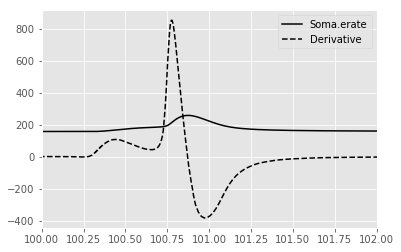

In [1135]:
plot(X1,Y1,'k-', label='Soma.erate')
plot(X1[:-1],deriv(Y1, X1)[0], 'k--',label='Derivative')
legend()
xlim(100,102)

In [35]:
def integrate_only_spike(yarr, xarr, x_boarders,frac=0.05,see='no'):
    '''
    In the interval given by `x_boarders` determine the `actual boarders`
    to integrate between. A criterion is set by `frac`:
    Actual boarders are the `yarr` indices where yarr ~= frac*yarr.max()
    '''
    x0=x_boarders[0]
    x1=x_boarders[1]
    idxb0 = map(lambda x: find_nearest(xarr,x), [x0,x1])

    # Cut curve from left and right. Make yarrn for `actual boarders` determine
    yarrn = yarr[idxb0[0]:idxb0[1]]
    tail = len(yarr[:idxb0[0]]) # how much is cut from the left. 
    yarrn = yarrn-yarrn.min()
    yarrn = yarrn/yarrn.max()
    
    # Determine limits of yarr integration from yarr
    Ma = yarrn.max()
    Xma = find_nearest(yarrn,Ma) # where to separate 
    th =  Ma*frac
#     print Ma, Xma
    if Xma < 0.1: # ih.erate curve has a minimum instead of max!
        Ma = yarrn.min()
        Xma = find_nearest(yarrn, Ma)
        th = 1-frac # find where 0.95 in ih.erate case
#     print th
    Xleft = find_nearest(yarrn[:Xma], th) # left lim
    Xright = find_nearest(yarrn[Xma:], th) + len(yarrn[:Xma]) # right lim
#     print Xleft, Xright
    # Calc yarr integral
    I0 = trapz(y=yarr[idxb0[0]:idxb0[1]],x=xarr[idxb0[0]:idxb0[1]])
    I_spike = trapz(y=yarr[Xleft+tail:Xright+tail], x=xarr[Xleft+tail:Xright+tail])
    
    if see == 'yes':
        xarray = xarr[idxb0[0]:idxb0[1]]
        figure()
        plot(xarray,yarr[idxb0[0]:idxb0[1]],label='Init Data')
#         plot(xarray,yarrn,'b',label='Init Data, normalized')
#         plot(xarray,ratios,'k--',label='Integral ratio')
#         plot(xarray[:-1], D1,label='Derivative of ratio')

        axvline(xarray[Xma],color='gray',label='Maxima')
        axvline(xarray[Xleft],color='m',label='Left')
        axvline(xarray[Xright], color='g',label='Right')
        legend(loc=6)
        show()
    
    return I_spike, I0#, Xleft+tail, Xright+tail # these are integration coordinates of init yarr
    
def integrate_all(data, x_boarders, frac=0.05,see='no',rep=0,mode=0):
    """
    `rep` == 1 => result is printed, `rep`==0 => not printed
    mode = 0 => integration within `actual boarderss`
    mode = 1 => integration within x_boarders
    """
    Erates = dict()
    x = data['t']
    for k in data.keys():
        if k[-4:] == 'rate':
            y = data[k]
            I = array(integrate_only_spike(y, x, x_boarders=x_boarders, frac=frac, see=see))*1e-3 # ms->s => pJ
#             print I
            I = J2atp(I)*6.022*10**11 # pJ -> ATPs
            if rep == 1:
                print k, 'is %.2e ATPs/Excitement'%I[0]
                print '             %.2e ATPs/Excitement -- without cutting, as in Etotal func'%I[1] + '\n-----'
            Erates.update({k:I[mode]}) # I[0] - with 'actual boarders', I[1] - with 'x_boarders' (see integrate_only_spikes func)
            
    SumEnergy = sum(Erates.values())
    Erates.update({'total.erate':SumEnergy})
    
    return Erates

In [1053]:
ocEfun = integrate_all(oc3_traj, [100,102])
ocElin = integrate_all(oc1_traj, [100,102])
ocEran = integrate_all(oc2_traj, [100,102])

### integrate only spikes

In [1054]:
# Integrate only spikes, within `actual boarders`
pandas.DataFrame(data=[ocEran,ocElin,ocEfun],index=['Random','Linear','Delay_func'])

,axon.erate,dend.erate,soma.erate,syn.erate,total.erate
Random,1.089341e+06,2.040996e+06,2.823362e+06,1.040693e+07,1.636063e+07
Linear,1.108626e+06,1.882254e+06,2.728849e+06,9.103270e+06,1.482300e+07
Delay_func,1.101715e+06,1.914284e+06,2.699217e+06,9.148101e+06,1.486332e+07


## calculate + Ih.erate and Ikl.erate

In [14]:
oc1,oc2,oc3 = OctopusCell(),OctopusCell(),OctopusCell()

In [15]:
tstop = 400

In [16]:

rate = 256.
oc1.add_synapses(tonotopy='ordered',gsyn=1.0, Nsyn=250, aud_rate=rate,aud_npulses=1,aud_start=300)
oc2.add_synapses(tonotopy='random',gsyn=1.0, Nsyn=300, aud_rate=rate,aud_npulses=1,aud_start=300)
# oc3.add_several_syn(locs=linspace(0,1,250),
#                     gsyn=1.0,
#                     afibp={'aud_npulses': 1,
#                            'aud_jitter': 0.0,
#                            'aud_start': 300,
#                            'aud_rate': 256}, dnm=[0,1,2,3],
#                     delay_func=lambda x: residual(out.params, x, mode='calc'))

In [17]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [18]:
%time data = go([oc1,oc2], mode='hkl')

 model time: 395.60002 ms 

CPU times: user 1min 20s, sys: 5.31 s, total: 1min 25s
Wall time: 1min 23s


In [19]:
oc1_traj,oc2_traj = data

In [ ]:
######################

In [189]:
ocErst = list(pmol2molecules(J2atp(array(instant_erates(oc1))))/500.) # axon, soma, dend, syn
ocErst.append(sum(ocErst)) # axon, soma, dend, syn, total
ocErst = {k:v for k,v in zip(['axon.erate','soma.erate','dend.erate','syn.erate','total.erate'], ocErst)}

In [104]:
# ocEfun = integrate_all(oc3_traj, [300,302], mode=1)
ocElin = integrate_all(oc1_traj, [300,302], mode=1) # mode =1 for integration within given boarders
ocEran = integrate_all(oc2_traj, [300,302], mode=1)

In [190]:
for k in ['ih.erate', 'ikl.erate']:
    ocEran.pop(k)
    ocElin.pop(k)

KeyError: 'ih.erate'

In [107]:
ocErst['axon.erate'] = ocErst.pop('Eaxon')
ocErst['soma.erate'] = ocErst.pop('Esoma')
ocErst['dend.erate'] = ocErst.pop('Edend')
ocErst['syn.erate'] = ocErst.pop('Esyn')
ocErst['total.erate'] = ocErst.pop('Etot')

In [23]:
import pandas

## For Article

In [197]:
ocEran_ = []
for i in range(len(data_r)):
    ocEran_.append(integrate_all(data_r[i][0], [150.5,152.5], mode=1))

In [198]:
vv = []
kk=[]
for i in range(len(ocEran_)):
    vv.append([v for k,v in ocEran_[i].items()])

In [199]:
ocEran_mean = {k:v for k,v in zip(ocElin.keys(), mean(vv, axis=0))}
ocEran_std = {k:v for k,v in zip(ocElin.keys(), std(vv, axis=0))}

In [200]:
# for article
P = pandas.DataFrame(data=[ocErst,ocElin,ocEran_mean],index=['Rest','Ordered','Random'])
print P
print '\nATPs consumed during 2 ms!'

           axon.erate    dend.erate    soma.erate     syn.erate   total.erate
Rest     2.408818e+03  1.479516e+06  3.703206e+06  5.433582e-49  5.185131e+06
Ordered  1.143409e+06  2.232197e+06  4.017729e+06  9.336940e+06  2.225988e+07
Random   3.915756e+06  2.277426e+06  1.149572e+06  1.096340e+07  1.830616e+07

ATPs consumed during 2 ms!


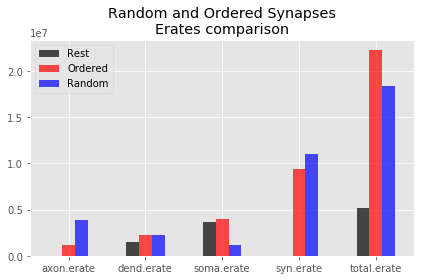

In [201]:
P.T.plot.bar(rot=0, color=['k','r','b'], alpha=0.7)
title('Random and Ordered Synapses\nErates comparison')
tight_layout()
# savefig('Compartments_Erates.eps')

In [113]:
print(4.31/22.03, 1.11/22.03)

(0.19564230594643664, 0.05038583749432592)


In [472]:
# 18.08.17 for article
a = find_nearest(oc1_traj['t'],250)
print 'Energy in resting OC for 2 ms\n------------'
print 'Ih   : %.2e'%(oc1_traj['ih.erate'][a]*2*1e-3 * 1e-12/5e4 * 6.022e23)
print 'Ikl  : %.2e'%(oc1_traj['ikl.erate'][a]*2*1e-3 * 1e-12/5e4 * 6.022e23)
print 'Total: %.2e'%((oc1_traj['axon.erate'][a] + oc1_traj['soma.erate'][a] +
                                 oc1_traj['dend.erate'][a] + oc1_traj['syn.erate'][a])*2*1e-3 * 1e-12/5e4 * 6.022e23)

Energy in resting OC for 2 ms
------------
Ih   : 4.97e+06
Ikl  : 2.08e+05
Total: 5.20e+06


In [475]:
print 'Ih and Ikl impacts to resting Erate:\n %.3f, %.3f'%(4.97/5.2, 0.21/5.2)

Ih and Ikl impacts to resting Erate:
 0.956, 0.040


### 18.08.17 for article
# Вклад Ih, Ikl = 19.56 и 5% при ПД. В iSpencer_energy_o 45 %
# Вклад Ih, Ikl = 95.57 и 4% в покое

In [521]:
Mesr.keys()

['Pyramidal', 'Octopus', 'Granule', 'Purkinje']

In [12]:
Ratiso = dict()
for ([kr,vr],[ka,va]) in zip(Mesr.items(),Mesa.items()):
    Ratiso[kr] = [i/j for i,j in zip(va,vr)]
print Ratiso

{'Grn': [1.3796791443850267], 'Pyr': [5.01123595505618], 'OC': [3.425925925925926, 0.8651911468812877, 5.238095238095238], 'Pur': [11.020408163265307]}


In [1]:
# *** Units:   ATPs/AP for all cells (AP durs: 2ms (OC, Grn), 1ms (Pur), 1.5ms (Pyr)) *** #

Mesrsec ={'OC':[2.7e9, 2.56e9, 0.1e9],   # Resting ATP per sec (Копия data.numbers)
      'Pur':[7.4e8] ,                 
      'Grn':[9.4e7]  ,                
      'Pyr':[4.5e8]}


Mesr ={'OC':[5.40e6, 4.97e6, 2.1e5],   # [[Resting],  # [Total, Ih, Ikl]
      'Pur':[7.37e5] ,       # forall: erates ratios from table Копия data.numbers 
      'Grn':[1.87e5]  ,       # (& Howarth 2012 & AP durations from a couple of articles)
      'Pyr':[6.68e5]}
      

Mesa = {'OC':[1.31e7, 4.30e6, 1.10e6], # Active (E_active(per sec) - E_rest(per sec))/AP_rate
        'Pur':[1.47e8],      
        'Grn':[3.57e7],
        'Pyr':[4.45e8]}


In [3]:
# --- AP-related elevation of Edemands ((E_AP-E_Rest)/E_Rest)

Ratiso = dict()
for ([kr,vr],[ka,va]) in zip(Mesr.items(),Mesa.items()):
    Ratiso[kr] = [i/j for i,j in zip(va,vr)]
print Ratiso


{'Grn': [190.9090909090909], 'Pyr': [666.1676646706587], 'OC': [2.425925925925926, 0.8651911468812877, 5.238095238095238], 'Pur': [199.4572591587517]}


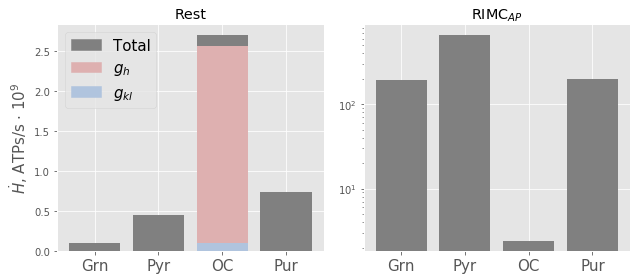

In [60]:
# *** Plotting this sh*t # 18.08.17 for article *** #


colrsr = ['grey','#deb0b0','#b0c4de'] # for total, ih, ikl, ika
lbls = ['Total', '$g_h$','$g_{kl}$']

#--- manually create labels and handles
import matplotlib.patches as mpatches
patches = []
for l,c in zip(lbls, colrsr):
    patches.append(mpatches.Patch(color=c, label=l))
#---

# **** Plottign **** #
fig, ax = subplots(1,2, figsize=(9,4))
# widths = [0.9, 0.8,0.7,0.7]
idxs = range(4)
for k,v,idx in zip(Mesrsec.keys(), Mesrsec.values(), idxs):
    if k == 'OC':
        for Me, cl in zip(v, colrsr):
            ax[0].bar(idx, Me/1e9, color=cl)
    else:
        ax[0].bar(idx, array(v)/1e9, color='grey')
        
ax[0].set_title('Rest')
ax[0].set_ylabel('$\dot{H}$, ATPs/s $\cdot$ 10$^9$', fontsize=15)
ax[0].legend(handles=patches, fontsize=15)
# ax[0].set_yscale('log')
# ax[0].set_ylim(1e1,1e10)
ax[0].set_xticks(range(4))
ax[0].set_xticklabels(Mesr.keys(), fontsize=15)

# Plotting ATPs per an AP at the right
# for k,v,idx in zip(Mesa.keys(), Mesa.values(), idxs):
#     if k == 'OC':
#         for Me, cl in zip(v, colrsr):
#             ax[1].bar(idx, Me/1e8, color='grey')
#     else:
#         ax[1].bar(idx, array(v)/1e8, color='grey')

# Plotting Ratios at the right
for k,v,idx in zip(Ratiso.keys(), Ratiso.values(), idxs):
    ax[1].bar(idx, v[0], color='grey')


ax[1].set_title('RIMC$_{AP}$')
# ax[1].set_ylabel('$\dot{H}_{AP}/\dot{H}_{Rest}$',fontsize=15)
ax[1].set_xticks(range(4))
# ax[1].set_yticks(range(0,800,200))
# ax[1].set_ylim(0,850)
ax[1].set_yscale('log')
ax[1].set_xticklabels(Mesa.keys(), fontsize=15)


tight_layout()
# savefig('Distrib-model-energy-bars.pdf')

## Сколько за 1 сек:

In [155]:
print atp2J(2.26e7/(6.022*1e23)*1e12)*500

938.226502823


# Spikeratio(Nsyn) with different GhGkl distributions

In [31]:
# from 'Current_distribution.ipynb'... APs are not generated there...

def count_synapses2(cell, Nsynv, gsyn=1.0, rate=256., npulses=25.,tonotopy='ordered',meth=0,
                   delay_func=None,dnm=[0,1,2,3],full_delay = 0.3):
    """
    Setting ``meth``=0 provides synapses set with ``add_synapses`` function.
    Set ``meth=1`` for ``add_several_syn`` function to be used.
    """
    acc = []
#     oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35) # Create a single cell. Rewriting of self.synapses is allowed
    for Nsyn in Nsynv:
#         oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
        if meth == 0:
            cell.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate,
                            tonotopy=tonotopy,full_delay = full_delay)
        elif meth == 1:
            cell.add_several_syn(locs=linspace(0,1,Nsyn), gsyn=gsyn,
                               afibp=dict(aud_rate=rate,
                                          aud_start=100,
                                          aud_npulses=npulses,
                                          aud_jitter=0.0),
                               dnm=dnm, delay_func=delay_func)
        apc = h.APCount(oc.ax_init(0.5))
        apc.thresh=-20
        h.tstop = 500
        h.v_init = -60.0
        h.run()
        sys.stderr.write('\r%d synapses, spike ratio: %0.2f'%(Nsyn, apc.n/npulses))
        acc.append([Nsyn, apc.n/npulses]) 
#         oc.delete()
#         del oc, apc 
        del apc
#     oc.delete()
#     del oc
    return acc   

In [20]:
h.tstop = 400

In [32]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [19]:
oc = OctopusCell(Ndendseg=501)

In [10]:
par = {'kh':linspace(0.0012,-0.0012,3),
       'bh': linspace(0.0,0.0012,3),
       'kkl':linspace(0.0054,-0.0054,3),
       'bkl':linspace(0.0,0.0054,3)}
lbl = ['grad>0','uniform','grad<0']

In [33]:
# Ordered syn delays
data_ord = {k:[] for k in lbl}
for i in range(3):
    for seg in chain(*oc.dendrites):
        seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
        seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
        
    %time acc = count_synapses2(oc,Nsynv=arange(230,260))
    
    k = lbl[i]
    data_ord[k].append(acc)
    
    for d in oc.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027

259 synapses, spike ratio: 1.00

CPU times: user 1h 1min 25s, sys: 28.8 s, total: 1h 1min 53s
Wall time: 1h 2min 51s


259 synapses, spike ratio: 1.00

CPU times: user 1h 8s, sys: 25.7 s, total: 1h 34s


256 synapses, spike ratio: 1.00

Wall time: 1h 1min 17s
CPU times: user 57min 26s, sys: 14.3 s, total: 57min 41s
Wall time: 58min 9s


259 synapses, spike ratio: 1.00

In [33]:
# Random synaptic delays
data_rand = {k:[] for k in lbl}
for i in range(3):
    for seg in chain(*oc.dendrites):
        seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
        seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
    
    %time acc_r = [count_synapses2(oc, range(240,321,5), tonotopy='random') for j in range(4)]

    k = lbl[i]
#     print k,acc_r
    data_rand[k].append(acc_r)
    
    for d in oc.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027

315 synapses, spike ratio: 1.00

CPU times: user 2h 22min 56s, sys: 5.54 s, total: 2h 23min 1s
Wall time: 2h 23min 2s


320 synapses, spike ratio: 1.00

CPU times: user 2h 22min 7s, sys: 5.48 s, total: 2h 22min 12s


310 synapses, spike ratio: 1.00

Wall time: 2h 22min 13s
CPU times: user 2h 22min 14s, sys: 5.78 s, total: 2h 22min 20s
Wall time: 2h 22min 21s


320 synapses, spike ratio: 1.00

In [34]:
data_r = {k:mean(v[0],axis=0).T for k,v in data_rand.items()}

In [34]:
data_or = dict()
for k,v in data_ord.items():
    data_or[k] = array(v)[0].T

## Delay times of  Gh, Gkl distrib

In [416]:
h.cvode.atol(1e-6)

1e-06

In [417]:
delays = {k:[] for k in lbl}
for i in range(3):
    # ----- set gh and gkl distribution
    for seg in chain(*oc.dendrites):
        seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
        seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
        
    acc, acc1=oc.find_delays(locs=arange(0,1,0.1),dnm=1,v_init=-59.6)
    acc[1] = acc[1]-acc[1][-1] # sit on zero
    acc[1] = array(acc[1]).max()-acc[1] # reverse
    
    k = lbl[i]
    print k
    delays[k].append(acc)
    for d in oc.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027

grad<0
uniform
grad>0


***
Total travelling wave delay = 0.00 ms
***
***
Total travelling wave delay = 0.00 ms
***
***
Total travelling wave delay = 0.00 ms
***


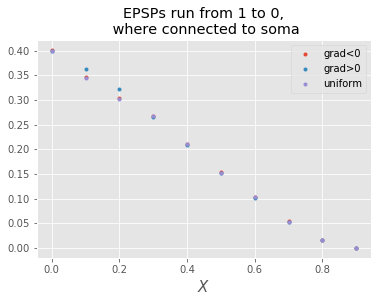

In [418]:
for k,v in delays.items():
    plot(v[0][0],v[0][1],'.',label=k)
    title('EPSPs run from 1 to 0,\n where connected to soma')
#     ylabel('$t_{V_{max}(X=0)-t_{aud\_start}$', fontsize=15)
    xlabel('$X$', fontsize=15)
    legend(loc='best')
#     print '***\nTotal travelling wave delay = %.2f ms\n***'%(acc[1].max()-acc[1][0])

# Figures for poster

In [7]:
import pandas

In [35]:
a = pandas.DataFrame(data=array([v[1] for v in data_or.values()]).T,
                     index=data_or['uniform'][0], columns=data_or.keys())
a.to_csv('Spike_ratio_ordered_hkl_variation2.csv')

In [58]:
c = pandas.read_csv('Spike_ratio_ordered_hkl_variation.csv')
Ns = c.columns[0]

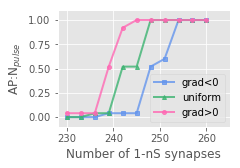

In [61]:
figure(figsize=(3.5,2.5))
for k in c.columns[1:]:
    plot(c[Ns], c[k],markers[k],markersize=4,color=colors[k], linewidth=2, alpha=0.8)
legend()
# title('AP/pulse with Gh, Gkl distribution variants.\nOrdered tonotopy')
xlabel('Number of 1-nS synapses')
ylim(-0.1,1.1)
xlim(228,265)
ylabel('AP:N$_{pulse}$')
# ylabel('Spike:npulse ratio')
tight_layout(pad=1.3)
savefig('AP-Npulse-ordered-256Hz.pdf')

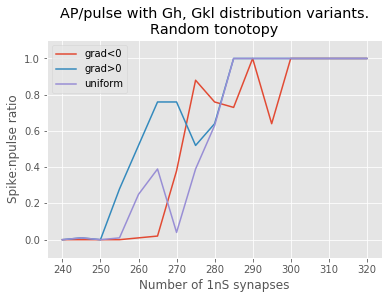

In [37]:
# Random
for k,v in data_r.items():
    plot(v[0],v[1],label=k)
legend(loc='best')
xlabel('Number of 1nS synapses')
title('AP/pulse with Gh, Gkl distribution variants.\nRandom tonotopy')
ylim(-0.1,1.1)
ylabel('AP:N$_{pulse}$')
# savefig('AP-of-npulse-random.pdf')

### AP & Erate in compartments

In [62]:
oc = OctopusCell(Ndendseg=501)

In [63]:
oc.add_synapses(Nsyn=250,gsyn=1.)

In [64]:
h.cvode.atol(1e-3)

0.001

In [66]:
h.tstop=500

In [71]:
traj = go([oc])

In [73]:
traj = traj[0]

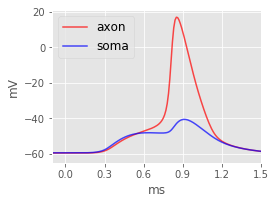

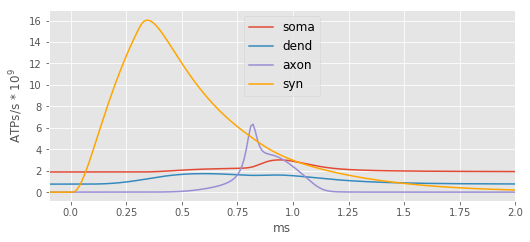

In [84]:


figure(figsize=(4,3))
plot(traj['t'], traj['axon.v'],'r-',label='axon', alpha=0.7)
plot(traj['t'], traj['soma.v'],'b-',label='soma', alpha=0.7)
legend(fontsize=12,loc=2)

xlim(99.9,101.5)
xticks(linspace(100,101.5,6),linspace(0,1.5,6))
xlabel('ms')
ylabel('mV')
tight_layout(pad=1.3)
# savefig('1_AP.pdf')

factor = avogadro*1e-12/(F_ATP*1e3)*1e-9 # pJ/s --> ATPs/s*1e-9
figure(figsize=(7.5,3.5))
plot(traj['t'], traj['soma.erate']*factor, '-', label='soma')
plot(traj['t'], traj['dend.erate']*factor, '-', label='dend')
plot(traj['t'], traj['axon.erate']*factor, '-', label='axon')
plot(traj['t'], traj['syn.erate']*factor, '-', color='orange', label='syn')
legend(loc=9, fontsize=12)
xticks(linspace(100,102,9),linspace(0,2,9))
xlabel('ms')
ylabel('ATPs/s * $10^9$')
xlim(99.9,102)
tight_layout(pad=1.2)
savefig('1_Erate.pdf')

In [9]:
# from 'Current_distribution.ipynb'... APs are not generated there...

def count_freq(cell, ratev, gsyn=1.0,Nsyn=260, npulses=25.,tonotopy='ordered',meth=0,
                   delay_func=None,dnm=[0,1,2,3],full_delay = 0.3):
    """
    Setting ``meth``=0 provides synapses set with ``add_synapses`` function.
    Set ``meth=1`` for ``add_several_syn`` function to be used.
    """
    acc = []
#     oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35) # Create a single cell. Rewriting of self.synapses is allowed
    for rate in ratev:
#         oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
        if meth == 0:
            cell.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate,
                            tonotopy=tonotopy,full_delay = full_delay)
        elif meth == 1:
            cell.add_several_syn(locs=linspace(0,1,Nsyn), gsyn=gsyn,
                               afibp=dict(aud_rate=rate,
                                          aud_start=100,
                                          aud_npulses=npulses,
                                          aud_jitter=0.0),
                               dnm=dnm, delay_func=delay_func)
        apc = h.APCount(oc.ax_init(0.5))
        apc.thresh=-20
        h.tstop = 400
        h.v_init = -60.0
        h.run()
        sys.stderr.write('\r pulse rate: %d, Hz; spike ratio: %0.2f'%(rate, apc.n/npulses))
        acc.append([rate, apc.n/npulses]) 
#         oc.delete()
#         del oc, apc 
        del apc
#     oc.delete()
#     del oc
    return acc   

In [8]:
oc = OctopusCell(Ndendseg=501)

In [10]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [15]:
datar_ord = {k:[] for k in lbl}
rs = range(250,311,20) + range(320,381,5) + range(390,451,20)
for i in range(3):
    for seg in chain(*oc.dendrites):
        seg.gbar_ihsab = par['bh'][i] + par['kh'][i]*seg.x
        seg.gbar_kltab = par['bkl'][i] + par['kkl'][i]*seg.x
    
    %time acc = count_freq(oc,ratev=rs)

    k = lbl[i]
    datar_ord[k].append(acc)
    
    for d in oc.dendrites:
        d.gbar_ihsab =  0.0006
        d.gbar_kltab =  0.0027


 pulse rate: 450, Hz; spike ratio: 0.04

CPU times: user 43min 49s, sys: 15.1 s, total: 44min 4s
Wall time: 44min 39s


 pulse rate: 450, Hz; spike ratio: 0.04

CPU times: user 42min 55s, sys: 14.2 s, total: 43min 9s
Wall time: 43min 35s


 pulse rate: 390, Hz; spike ratio: 0.04

CPU times: user 40min 30s, sys: 5.55 s, total: 40min 36s
Wall time: 40min 45s


 pulse rate: 450, Hz; spike ratio: 0.04

In [17]:
datar_or = dict()
for k,v in datar_ord.items():
    datar_or[k] = array(v)[0].T

In [ ]:
# a = pandas.DataFrame(data=array([v[1] for v in datar_or.values()]).T,
#                      index=datar_or['uniform'][0], columns=datar_or.keys())
# a.to_csv('Spike_ratio-PulseRateVary-260syn_ordered_hkl_variation.csv')

In [25]:
colors = {k:v for k,v in zip(lbl,['#FF69B4','#3cb371','#6495ED'])}

In [42]:
import pandas

In [12]:
datar_or = pandas.read_csv('Spike_ratio-PulseRateVary-260syn_ordered_hkl_variation.csv')

In [13]:
markers = {k:v for k,v in zip(lbl,['o-','^-','s-'])}

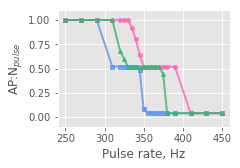

In [41]:

x = datar_or['Unnamed: 0']
figure(figsize=(3.5,2.5))
for k,v in datar_or.iteritems():
    if k != 'Unnamed: 0':
        plot(x,v,markers[k],markersize=4,label=k,   color=colors[k], linewidth=2,alpha=0.8)
# legend()
# title('AP/pulse with Gh, Gkl distribution variants.\nOrdered tonotopy, 260 synapses')
xlabel('Pulse rate, Hz')
ylim(-0.1,1.1)
ylabel('AP:N$_{pulse}$')
tight_layout(pad=1.3)
savefig('AP-Pulse-260syn-ofPulseRate.pdf')